<a href="https://colab.research.google.com/github/IgorStellet/Casual_Works/blob/main/FP1_2025_2_T3_2_IgorStellet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Igor Almeida da Silva Gouvêa Stellet

# Tarefa 3 - Parte 3

## Bibliotecas e Funções

In [ ]:
#Bibliotecas que serão utilizadas
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
import scipy.stats
import scipy.optimize
from scipy.interpolate import CubicSpline, interp1d
import numpy as np
from IPython.display import HTML
from google.colab import files
from IPython.display import Image
from math import comb
import pandas as pd

In [ ]:
# Setup de Funções para o modelo de ising (dia 1)


#1) ------- Criar Rede (lattice) de spins --------

def begin_lattice(L, tipo="random", seed=None):
    """
    Inicializa uma rede LxL de spins (+1 ou -1).

    Parâmetros:
      L (int): tamanho do lado da rede
      tipo (str): "random" (spins aleatórios) ou "up" (todos +1)
      seed (int, opcional): semente para reprodutibilidade

    Retorna:
      lattice (np.array): rede LxL com spins
    """
    if seed is not None:
        np.random.seed(seed)

    if tipo == "random":
        lattice = np.random.choice([-1, 1], size=(L, L))
    elif tipo == "up":
        lattice = np.ones((L, L), dtype=int)
    else:
        raise ValueError("tipo deve ser 'random' ou 'up'")

    return lattice

#2) ------- Calcular a energia local do spin i,j com seus 4 vizinhos --------

def local_energe(lattice, i, j, J=1.0, H=0.0):
    """
    Calcula a energia local do spin (i,j) com seus 4 vizinhos.

    Parâmetros:
      lattice (array): Matriz dos spins
      (i,j) (int): posição do spin que queremos avaliar
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)

    Retorna:
      E_ij (float): energia local do spin (i,j)
    """
    L = lattice.shape[0]
    s = lattice[i, j]

    # 4 vizinhos com contorno periódico
    # O resto da divisão garante que uma ponta da matriz está conectada com a outra ponta
    vizinhos = (
        lattice[(i+1) % L, j] +
        lattice[(i-1) % L, j] +
        lattice[i, (j+1) % L] +
        lattice[i, (j-1) % L]
    )

    # energia local
    E_ij = -J * s * vizinhos - H * s
    return E_ij

#3) ------- Calcula a diferença de energia dado um flip de spin --------

def delta_energe(lattice, i, j, J=1.0, H=0.0):
    """
    Calcula a variação de energia caso o spin (i,j) seja flipado.

    Parâmetros:
      lattice (array): Matriz dos spins
      (i,j) (int): posição do spin que queremos avaliar
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)

    Retorna:
      Delta E (float): variação de energia
    """
    L = lattice.shape[0]
    s = lattice[i, j]

    # soma dos vizinhos com contorno periódico
    vizinhos = (
        lattice[(i+1) % L, j] +
        lattice[(i-1) % L, j] +
        lattice[i, (j+1) % L] +
        lattice[i, (j-1) % L]
    )

    # fórmula direta
    deltaE = 2 * J * s * vizinhos + 2 * H * s
    return deltaE

#4) ------- Aplica o modelo de metropolis para flipar os spins --------

def metropolis_step(lattice, T, J=1.0, H=0.0):
    """
    Atualiza a rede com o modelo metropolis.

    Parâmetros:
      lattice (array): rede atual (modificada in-place)
      T (float): Temperatura do sistema (deve ser maior que 0)
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)

    Retorna:
      lattice (array): rede atualizado (mesma referência, in-place)
    """
    L = lattice.shape[0]
    i = np.random.choice(L)
    j = np.random.choice(L)
    s = lattice[i][j]

    deltaE = delta_energe(lattice, i, j, J, H)

    if deltaE <= 0:
      lattice[i][j] = -s

    else:
      if np.random.rand() < np.exp(-deltaE/T):
        lattice[i][j] = -s

    return lattice

#5) ------- Executa N tentativar de Flipe (com N=L^2) - Um sweep completo --------

def metropolis_sweep(lattice, T, J=1.0, H=0.0):
    """
    Atualiza a rede com o modelo metropolis.

    Parâmetros:
      lattice (array): rede atual (modificada in-place)
      T (float): Temperatura do sistema (deve ser maior que 0)
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)

    Retorna:
      lattice (array): rede atualizado (mesma referência, in-place) após N tentativas de Flip
    """
    L = lattice.shape[0]
    N = L * L
    for _ in range(N):
       lattice = metropolis_step(lattice, T, J, H)

    return lattice

#6) ------- Encontra o valor escalar da magnetização do sistema --------

def magnetization(lattice):
    """
    Calcula a magnetização média do sistema

    Parâmetros:
      lattice (array): rede
    Retorna:
      Mag (float): magnetização do sistema
    """
    L = lattice.shape[0]
    N = L * L
    M = 1/N * np.sum(lattice)
    return M

#7) ------- Encontra a energia total do sistema --------

def total_energe(lattice, J=1.0, H=0.0):
    """
    Calcula a energia total do sistema de Ising.

    Parâmetros:
      lattice (array): rede atual (modificada in-place)
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)
    Retorna:
      Energia total do sistema
    """
    L = lattice.shape[0]
    N = L * L
    Etot = 0
    for i in range(L):
      for j in range(L):
        Etot += local_energe(lattice, i, j, J, H)

    Etot = Etot/2 -H*np.sum(lattice)/2 # Garantir que não está fazendo a contagem dupla da interação com vizinhos

    return Etot
####################### Fim do dia 1 #######################
# Setup de Funções para o wolf (dia 2)


#8) ------- Teramaliza a rede em temperatura T --------

def run_equilibrate(lattice, T, n_therm_sweeps, J=1.0, H=0.0 ):
  """
    Termaliza a rede a uma temperatura T, descartando medidas

    Parâmetros:
      lattice (array): rede atual (modificada in-place)
      J (float): Constante de acoplamento (default 1.0)
      H (float): Campo externo (default 0.0)
      T (float0): Temperatura desejada para termalização
      n_therm_sweeps(int): Sweeps desejados para termializar a rede
    Retorna:
      lattice termailizada a temperatura T
  """
  for _ in range(n_therm_sweeps):
     metropolis_sweep(lattice, T, J, H)

  return lattice

#9) ------- Mede a magnetização e eneriga para alguns valores desejados --------

def measure_observables(lattice, T, n_sweeps, sample_every, J=1.0, H=0.0):
  """
   Temperatura na qual serão coletadas as medidas (assume que a rede já está equilibrada)

    Parâmetros:
      lattice (array): rede atual (modificada in-place)
      T (float): Temperatura na qual serão coletadas as medidas (rede já equlibrada)
      n_sweeps(int): Sweeps desejados para coletar dados
      sample_every (int): intevalo em sweeps entre medidas
    Retorna:
      M(array): Lista com os valores da magnetização
      E(array): Lista com os valroes de energia
  """
  M_samples, E_samples = [], []
  for sweep in range(n_sweeps):
    metropolis_sweep(lattice, T, J, H)
    if sweep % sample_every == 0:
      M = magnetization(lattice)
      E = total_energe(lattice)
      M_samples.append(M)
      E_samples.append(E)

  return np.array(M_samples), np.array(E_samples)


#10) ------- Calcula os observáveis físicos de interesse --------

def compute_observables(M_samples, E_samples, T, L):
  """
  Calcula os observáveis de interessse a partir de amostrar de M e E
    Parâmetros:
      L (int): Tamanho da rede
      T (float): Temperatura na qual serão coletadas as medidas (rede já equlibrada)
      M_samples(array): Lista dos valores de Média coletados
      E_samples (array): Lista com os valores de energia coletados
    Retorna:
      M_abs (float): magnetização média absoluta
      chi (float): susceptibilidade
      C (float): calor específico
      U (float): cumulante de Binder
      E_mean (float): energia média
  """
  N = L * L
  beta = 1.0 / T
  M_mean = np.mean(M_samples)
  M_abs = np.mean(np.abs(M_samples))
  M2 = np.mean(M_samples ** 2 )
  M4 = np.mean(M_samples ** 4 )

  E_mean = np.mean(E_samples)
  E2 = np.mean(E_samples **2)

  chi = beta * (M2 - M_mean ** 2) * N
  C =beta ** 2 *(E2 - E_mean**2) / N
  U = 1- M4/(3*(M2**2))

  return M_abs, chi, C, U, E_mean

#11) ------- Calula erro e desvio padrão substituindo valores da amostra --------

def bootstrap(data, n_resamples=1000):
    """
    Estima média e erro (desvio padrão) por bootstrap.
    """
    N = len(data)
    means = []
    for _ in range(n_resamples):
        sample = np.random.choice(data, size=N, replace=True)
        means.append(np.mean(sample))
    return np.mean(means), np.std(means)

################# CORAÇÃO DO CÓDIGO #################
#12) ------- Lista os valores de observáveis para diversos T --------

def scan_temperature(L, T_values, n_therm, n_sweeps, sample_every,
                     seed=None, J=1.0, H=0.0, tipo="random", n_resamples=500):
    """
    Roda simulação para uma lista de temperaturas e retorna observáveis
    com erros estimados por bootstrap.

    Parâmetros:
      L (int)                 : tamanho da rede
      T_values (iterável)     : temperaturas a simular (ordenadas)
      n_therm (int)           : sweeps de termalização por T
      n_sweeps (int)          : sweeps de medição por T
      sample_every (int)      : intervalo entre amostras
      seed (int|None)         : semente global (fixada uma vez no início)
      J, H (float)            : acoplamento e campo
      tipo (str)              : "random" ou "up"
      n_resamples (int)       : reamostragens para bootstrap

    Retorna:
      results (list of dicts): cada entrada contém T, <|M|>, chi, C, U, E_mean
                               e os respectivos erros.
    """
    results = []

    # Se quiser reprodutibilidade, fixe seed uma vez só
    if seed is not None:
        np.random.seed(seed)

    for idx, T in enumerate(T_values):
        # Cria rede inicial (sem seed fixa por T, para não repetir)
        lattice = begin_lattice(L, tipo=tipo)

        # Termaliza a rede
        run_equilibrate(lattice, T, n_therm, J, H)

        # Mede amostras
        M_samples, E_samples = measure_observables(
            lattice, T, n_sweeps, sample_every, J, H
        )

        # Calcula observáveis centrais
        M_abs, chi, C, U, E_mean = compute_observables(M_samples, E_samples, T, L)

        # Erros por bootstrap
        M_abs_bs, dM_abs = bootstrap(np.abs(M_samples), n_resamples)
        chi_bs, dchi = bootstrap(
            (M_samples**2 - M_abs_bs**2) * (1.0/T) * (L*L), n_resamples
        )
        C_bs, dC = bootstrap(
            (E_samples**2 - E_mean**2) * (1.0/T**2) / (L*L), n_resamples
        )
        U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)
        E_bs, dE = bootstrap(E_samples, n_resamples)

        results.append({
            "T": T,
            "M_abs": M_abs, "dM_abs": dM_abs,
            "chi": chi, "dchi": dchi,
            "C": C, "dC": dC,
            "U": U, "dU": dU,
            "E_mean": E_mean, "dE": dE
        })

    return results

####################### Fim do dia 2 #######################
# Calculo do Binder Cumulant e T_C por curzamento (dia 3)

#13) ------- Salva apenas o cumulante de Blinder para diversas Temperaturas --------

def build_binder_curve(
    L, T_values, n_therm, n_sweeps, sample_every,
    seed=None, J=1.0, H=0.0, tipo="random", n_resamples=500,
    save_csv_path=None
):
    """
    Roda a simulação para uma lista de temperaturas e retorna apenas
    a curva do cumulante de Binder para o tamanho L especificado.

    Parâmetros:
      L (int)                 : tamanho da rede
      T_values (iterável)     : temperaturas a simular (ordenadas)
      n_therm (int)           : sweeps de termalização por T
      n_sweeps (int)          : sweeps de medição por T
      sample_every (int)      : intervalo entre amostras
      seed (int|None)         : semente global (fixada uma vez no início)
      J, H (float)            : acoplamento e campo
      tipo (str)              : "random" ou "up"
      n_resamples (int)       : reamostragens para bootstrap
      save_csv_path (str|None): se fornecido, salva CSV com T, U, dU

    Retorna:
      T (np.ndarray), U (np.ndarray), dU (np.ndarray)
    """
    # roda simulação (usa o seed recebido)
    results = scan_temperature(
        L=L,
        T_values=T_values,
        n_therm=n_therm,
        n_sweeps=n_sweeps,
        sample_every=sample_every,
        seed=seed,
        J=J,
        H=H,
        tipo=tipo,
        n_resamples=n_resamples
    )

    # extrai apenas Binder
    T  = np.array([r["T"]  for r in results], dtype=float)
    U  = np.array([r["U"]  for r in results], dtype=float)
    dU = np.array([r["dU"] for r in results], dtype=float)

    # ordena por T (por segurança)
    order = np.argsort(T)
    T, U, dU = T[order], U[order], dU[order]

    # salva CSV opcionalmente
    if save_csv_path is not None:
        import pandas as pd
        df = pd.DataFrame({"T": T, "U": U, "dU": dU})
        df.to_csv(save_csv_path, index=False)

    return T, U, dU


#14) ------- Cria um interpolador suave para avaliar U(T) em T contínuo --------

def interpolate_U(T, U, kind="cubic", bounds="raise"):
    """
    Constrói um interpolador suave U_interp(t) para o Binder U(T). Isso serve para
    encontrar o cruzamento de binder de uma forma melhor e mais certeira, criando uma função
    contínua de U.

    Parâmetros
    ----------
    T : array-like (1D)
        Temperaturas medidas (não precisa estar ordenado).
    U : array-like (1D)
        Valores do cumulante de Binder correspondentes a T.
    kind : {"cubic","linear"}, opcional
        Tipo de interpolação (default: "cubic").
    bounds : {"raise","nan","clamp"}, opcional
        Política para t fora do domínio [min(T), max(T)].

    Retorna
    -------
    U_interp : callable
        Função que aceita escalar ou array: U_interp(t) -> U(t).
    """
    T = np.asarray(T, dtype=float).ravel()
    U = np.asarray(U, dtype=float).ravel()
    if T.size != U.size:
        raise ValueError("T e U devem ter o mesmo tamanho.")

    # 1) Ordena e agrega duplicatas por média
    order = np.argsort(T)
    T, U = T[order], U[order]
    unique_T, inv = np.unique(T, return_inverse=True)
    if unique_T.size != T.size:
        U_agg = np.zeros_like(unique_T, dtype=float)
        counts = np.zeros_like(unique_T, dtype=float)
        for k, idx in enumerate(inv):
            U_agg[idx] += U[k]
            counts[idx] += 1.0
        T, U = unique_T, (U_agg / counts)

    if T.size < 2:
        raise ValueError("São necessários pelo menos 2 pontos únicos em T.")

    Tmin, Tmax = T[0], T[-1]

    # 2) Escolhe interpolador
    if kind == "cubic":
        if T.size < 4:
            # cúbica precisa de pelo menos 4 pontos -> cai para linear
            f = interp1d(T, U, kind="linear", bounds_error=False,
                         fill_value=np.nan, assume_sorted=True)
            mode = "linear"
        else:
            cs = CubicSpline(T, U, bc_type="natural", extrapolate=False)
            mode = "cubic"
    elif kind == "linear":
        f = interp1d(T, U, kind="linear", bounds_error=False,
                     fill_value=np.nan, assume_sorted=True)
        mode = "linear"
    else:
        raise ValueError("kind deve ser 'cubic' ou 'linear'.")

    # 3) Wrapper com política de borda
    def U_interp(t):
        x = np.asarray(t, dtype=float)
        if mode == "cubic":
            # CubicSpline com extrapolate=False retorna NaN fora do domínio
            y = cs(x)
        else:
            y = f(x)  # interp1d já devolve NaN fora do domínio

        if bounds == "raise":
            if np.any((x < Tmin) | (x > Tmax)):
                raise ValueError("t fora do domínio de interpolação.")
            return y
        elif bounds == "nan":
            return y
        elif bounds == "clamp":
            # avalia em valores clipados, garantindo retorno nas bordas
            x_clamped = np.clip(x, Tmin, Tmax)
            if mode == "cubic":
                return cs(x_clamped)
            else:
                return f(x_clamped)
        else:
            raise ValueError("bounds deve ser 'raise', 'nan' ou 'clamp'.")

    return U_interp


#15) ------- Encontra o cruzamento de duas curvas de binder --------

def find_crossing(T1, U1, T2, U2, *,
                  kind="cubic",
                  bounds="raise",
                  bracket=None,
                  t_guess=None,
                  grid_points=400,
                  return_U_at_cross=True):
    """
    Encontra o cruzamento entre duas curvas de Binder U1(T) e U2(T).

    Parâmetros
    ----------
    T1, U1 : arrays 1D   | Curva para L1
    T2, U2 : arrays 1D   | Curva para L2
    kind : {"cubic","linear"}    | Interpolação a usar (passado a interpolate_U)
    bounds : {"raise","nan","clamp"} | Política de borda da interpolação
    bracket : (t_min, t_max) ou None | Intervalo de busca; se None usa o overlap dos domínios
    t_guess : float ou None | Palpite para escolher raiz se houver múltiplas
    grid_points : int | Pontos na malha inicial para detectar mudança de sinal
    return_U_at_cross : bool | Se True, retorna também U no cruzamento

    Retorna
    -------
    t_cross  (e opcionalmente)  U_cross
    """
    # 1) Interpoladores contínuos
    U1_interp = interpolate_U(T1, U1, kind=kind, bounds="nan")
    U2_interp = interpolate_U(T2, U2, kind=kind, bounds="nan")

    # 2) Define intervalo de busca (overlap se bracket=None)
    dom1 = (np.min(T1), np.max(T1))
    dom2 = (np.min(T2), np.max(T2))
    tmin = max(dom1[0], dom2[0])
    tmax = min(dom1[1], dom2[1])

    if bracket is not None:
        bmin, bmax = bracket
        if bmin > bmax:
            bmin, bmax = bmax, bmin
        tmin = max(tmin, bmin)
        tmax = min(tmax, bmax)

    if not (tmin < tmax):
        raise ValueError("Sem overlap de domínios/intervalos para buscar o cruzamento.")

    # 3) Função diferença
    def f(t):
        return U1_interp(t) - U2_interp(t)

    # 4) Malha grossa: detectar mudanças de sinal
    ts = np.linspace(tmin, tmax, int(grid_points) + 1)
    fs = f(ts)

    # Remover pontos com NaN
    mask = np.isfinite(fs)
    ts, fs = ts[mask], fs[mask]
    if ts.size < 2:
        raise RuntimeError("Interpolação devolveu valores inválidos no intervalo escolhido.")

    # Detectar subintervalos com troca de sinal (ou zero exato)
    sign_changes = []
    for i in range(len(ts) - 1):
        a, b = ts[i], ts[i+1]
        fa, fb = fs[i], fs[i+1]
        if not (np.isfinite(fa) and np.isfinite(fb)):
            continue
        if fa == 0.0:
            sign_changes.append((a, a))  # raiz exata em a
        elif fa * fb < 0.0:
            sign_changes.append((a, b))
        elif fb == 0.0:
            sign_changes.append((b, b))  # raiz exata em b

    if len(sign_changes) == 0:
        raise RuntimeError(
            "Não encontrei mudança de sinal em U1-U2 no intervalo. "
            "Tente aumentar a densidade de T, ajustar 'bracket', ou usar kind='linear'."
        )

    # 5) Refinar cada candidato com brentq (quando necessário)
    roots = []
    for (a, b) in sign_changes:
        if a == b:
            roots.append(a)
            continue
        fa, fb = f(a), f(b)
        # pode ocorrer fa==0 ou fb==0 por numérico; brentq exige sinais opostos
        if fa == 0.0:
            roots.append(a)
            continue
        if fb == 0.0:
            roots.append(b)
            continue
        # garantir sinais opostos (pequeno ajuste, se necessário)
        try:
            r = scipy.optimize.brentq(lambda x: f(x), a, b, maxiter=100)
            roots.append(r)
        except ValueError:
            # se por algum motivo não deu (por ex. ambos do mesmo sinal após arredondamentos), ignore este intervalo
            continue

    if len(roots) == 0:
        raise RuntimeError("Falha ao refinar a raiz; ajuste 'bracket' ou 'grid_points'.")

    roots = np.array(sorted(roots))

    # 6) Escolher raiz (se múltiplas)
    if t_guess is not None and np.isfinite(t_guess):
        idx = np.argmin(np.abs(roots - t_guess))
    else:
        center = 0.5 * (tmin + tmax)
        idx = np.argmin(np.abs(roots - center))

    t_cross = float(roots[idx])
    if return_U_at_cross:
        U_cross = float(U1_interp(t_cross))  # ≈ U2_interp(t_cross)
        return t_cross, U_cross
    else:
        return t_cross

#16) ------- Encontra T_c com base no cruzamento --------
def estimate_Tc_from_crossings(crossings, *,
                               method="extrapolate",
                               nu=1.0,
                               return_fit=False,
                               n_bootstrap=None,
                               random_state=None):
    """
    Estima Tc a partir de cruzamentos de Binder entre pares (L, 2L).

    Parâmetros
    ----------
    crossings : list
        Lista com tuplas por par (L, 2L). Formatos aceitos por item:
          - (L, T_cross)
          - (L, T_cross, dT_cross)   # com incerteza opcional
        Ex.: [(16, 2.2701, 0.002), (24, 2.2690, 0.0015), (32, 2.2686, 0.0012)]
        (O L passado é sempre o MENOR do par; assume-se cruzamento L vs 2L.)
    method : {"extrapolate","average"}
        "extrapolate": ajuste linear de T_cross vs L^{-1/nu} e Tc = intercepto.
        "average": média simples (ou ponderada, se houver dT).
    nu : float
        Expoente de correlação (Ising 2D: nu=1). Usado na abscissa L^{-1/nu}.
    return_fit : bool
        Se True, retorna também um dicionário com detalhes do ajuste.
    n_bootstrap : int ou None
        Se fornecido, realiza bootstrap das entradas (com reposição) e
        reporta o desvio-padrão bootstrap do Tc.
    random_state : int ou None
        Semente para o gerador do bootstrap.

    Retornos
    --------
    Tc : float
        Estimativa final da temperatura crítica.
    fit_info : dict (opcional, se return_fit=True)
        Detalhes do ajuste: método, nu, n, slope, intercept, erros, R^2, etc.

    Notas
    -----
    - Para "extrapolate": se dT for fornecido, usa ajuste ponderado (w = 1/sigma).
      O erro do intercepto vem da matriz de covariância do ajuste linear.
    - Para "average": se dT for fornecido, usa média ponderada por 1/sigma^2.
    - Se n_bootstrap for fornecido, também calcula 'Tc_bootstrap_std'.
    """

    if not crossings:
        raise ValueError("Lista 'crossings' vazia.")

    # Parse das entradas
    Ls, Ts, dTs = [], [], []
    for item in crossings:
        if len(item) == 2:
            L, T = item
            dT = None
        elif len(item) == 3:
            L, T, dT = item
        else:
            raise ValueError("Cada item de 'crossings' deve ser (L, T) ou (L, T, dT).")
        Ls.append(float(L))
        Ts.append(float(T))
        dTs.append(None if dT is None else float(dT))

    Ls = np.asarray(Ls, dtype=float)
    Ts = np.asarray(Ts, dtype=float)
    dTs = np.array([np.nan if d is None else d for d in dTs], dtype=float)

    # Ordena por L crescente
    order = np.argsort(Ls)
    Ls, Ts, dTs = Ls[order], Ts[order], dTs[order]

    fit_info = {
        "method": method,
        "nu": nu,
        "n": len(Ls),
        "Ls": Ls.copy(),
        "Ts": Ts.copy(),
        "dTs": dTs.copy(),
    }

    rng = np.random.default_rng(random_state)

    if method == "average":
        # Média simples/ponderada
        if np.all(np.isnan(dTs)):
            Tc = float(np.mean(Ts))
            Tc_err = float(np.std(Ts, ddof=1) / np.sqrt(len(Ts))) if len(Ts) > 1 else np.nan
        else:
            # pesos = 1/sigma^2
            sig = dTs.copy()
            # evita divisões por zero/NaN: usa apenas pontos com sigma finito e >0
            mask = np.isfinite(sig) & (sig > 0)
            if not np.any(mask):
                Tc = float(np.mean(Ts))
                Tc_err = float(np.std(Ts, ddof=1) / np.sqrt(len(Ts))) if len(Ts) > 1 else np.nan
            else:
                w = 1.0 / (sig[mask]**2)
                Tsel = Ts[mask]
                Tc = float(np.sum(w * Tsel) / np.sum(w))
                Tc_err = float(np.sqrt(1.0 / np.sum(w)))

        # Bootstrap (opcional)
        Tc_bootstrap_std = None
        if isinstance(n_bootstrap, int) and n_bootstrap > 0:
            boots = []
            n = len(Ts)
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)  # reamostra índices
                Tb = Ts[idx]
                db = dTs[idx]
                if np.all(np.isnan(db)):
                    boots.append(np.mean(Tb))
                else:
                    maskb = np.isfinite(db) & (db > 0)
                    if not np.any(maskb):
                        boots.append(np.mean(Tb))
                    else:
                        w = 1.0 / (db[maskb]**2)
                        boots.append(np.sum(w * Tb[maskb]) / np.sum(w))
            Tc_bootstrap_std = float(np.std(boots, ddof=1))
        fit_info.update({"Tc_err": Tc_err, "Tc_bootstrap_std": Tc_bootstrap_std})
        return (Tc, fit_info) if return_fit else Tc

    elif method == "extrapolate":
        if len(Ls) < 2:
            raise ValueError("Extrapolação requer ao menos 2 cruzamentos (2 pares L,2L).")

        x = Ls ** (-1.0 / float(nu))  # abscissa
        y = Ts

        # Ajuste linear y = a*x + b; Tc = b (intercepto)
        # Ponderação: w = 1/sigma  (equivalente a minimizar (y - f)^2 / sigma^2)
        has_sigma = np.any(np.isfinite(dTs))
        if has_sigma:
            sig = dTs.copy()
            # Onde não há incerteza, use um sigma grande para pequena influência
            sig[~np.isfinite(sig) | (sig <= 0)] = np.nanmax(sig[np.isfinite(sig)]) * 1e3
            w = 1.0 / sig
        else:
            w = None

        if w is None:
            coeffs, cov = np.polyfit(x, y, deg=1, cov=True)
        else:
            coeffs, cov = np.polyfit(x, y, deg=1, w=w, cov=True)

        a, b = coeffs[0], coeffs[1]
        Tc = float(b)
        # Erros do ajuste (desvio padrão dos coeficientes)
        slope_err = float(np.sqrt(cov[0, 0]))
        intercept_err = float(np.sqrt(cov[1, 1]))

        # Métrica R^2
        yhat = a * x + b
        ss_res = float(np.sum((y - yhat) ** 2))
        ss_tot = float(np.sum((y - np.mean(y)) ** 2)) if len(y) > 1 else np.nan
        R2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

        # Bootstrap (opcional): reamostra os pares (x,y,sigma)
        Tc_bootstrap_std = None
        if isinstance(n_bootstrap, int) and n_bootstrap > 0:
            boots = []
            n = len(x)
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                xb, yb = x[idx], y[idx]
                if has_sigma:
                    sigb = dTs[idx]
                    sigb[~np.isfinite(sigb) | (sigb <= 0)] = np.nanmax(sigb[np.isfinite(sigb)]) * 1e3
                    wb = 1.0 / sigb
                    cb, covb = np.polyfit(xb, yb, deg=1, w=wb, cov=True)
                else:
                    cb, covb = np.polyfit(xb, yb, deg=1, cov=True)
                boots.append(cb[1])  # intercepto
            Tc_bootstrap_std = float(np.std(boots, ddof=1))

        fit_info.update({
            "x": x, "y": y, "weights": w,
            "slope": float(a), "slope_err": slope_err,
            "intercept": Tc, "intercept_err": intercept_err,
            "R2": float(R2),
            "Tc_bootstrap_std": Tc_bootstrap_std
        })
        return (Tc, fit_info) if return_fit else Tc

    else:
        raise ValueError("method deve ser 'extrapolate' ou 'average'.")

####################### Fim do dia 3 #######################
# Calculo dos expoentes críticos do ising 2D - Dia 4

#17) ------- Obter pico de uma curva amostrada em T (e.g.:suscepitibilidade ou calor específico) --------

def extract_peak(T, Y, dY=None, *, method="quadratic", k=2,
                 return_indices=False, bootstrap=None, seed=None):
    """
    Entra:
      T (1D array): temperaturas (pode não estar ordenado)
      Y (1D array): observable em T (mesmo tamanho de T)
      dY (1D array|None): erro de Y (opcional; se dado, usado p/ pesos/boot)
      method ("quadratic"|"argmax"):
         - "quadratic": ajusta parábola local ao redor do máximo bruto;
         - "argmax": usa simplesmente o maior Y da grade (sem subgrade).
      k (int): nº de pontos de cada lado do máximo bruto para o ajuste
               (ex.: k=2 → usa 5 pontos: max±0,1,2)
      return_indices (bool): se True, retorna também os índices usados no ajuste
      bootstrap (int|None): nº de reamostragens p/ estimar erros (σT*, σY*)
      seed (int|None): semente do gerador do bootstrap

    Retorna (varia conforme flags):
      - T_star, Y_star
      - se bootstrap: T_star, Y_star, dT_star, dY_star
      - se return_indices: ... , idx_window  (lista de índices relativos ao array ORDENADO)

    Erros:
      - ValueError se T e Y tiverem tamanhos diferentes.
      - ValueError se não houver pontos suficientes na janela (>=3 p/ ajuste quadrático).
    """
    T = np.asarray(T, dtype=float).ravel()
    Y = np.asarray(Y, dtype=float).ravel()
    if T.size != Y.size:
        raise ValueError("T e Y devem ter o mesmo tamanho.")

    if dY is not None:
        dY = np.asarray(dY, dtype=float).ravel()
        if dY.size != T.size:
            raise ValueError("dY deve ter o mesmo tamanho de T e Y.")
    # 1) Ordena por T (e reordena Y, dY)
    order = np.argsort(T)
    T, Y = T[order], Y[order]
    dY = dY[order] if dY is not None else None

    # 2) Índice do máximo “bruto” (em grade)
    i_max = int(np.argmax(Y))
    T_brut, Y_brut = T[i_max], Y[i_max]

    # Caminho simples: só o valor em grade
    if method == "argmax":
        # Bootstrap simples (opcional)
        if isinstance(bootstrap, int) and bootstrap > 0 and dY is not None:
            rng = np.random.default_rng(seed)
            Tb, Yb = [], []
            for _ in range(bootstrap):
                Y_pert = Y + rng.normal(0.0, dY, size=Y.shape)
                j = int(np.argmax(Y_pert))
                Tb.append(T[j]); Yb.append(Y_pert[j])
            dT_star = float(np.std(Tb, ddof=1)) if len(Tb) > 1 else np.nan
            dY_star = float(np.std(Yb, ddof=1)) if len(Yb) > 1 else np.nan
            if return_indices:
                return T_brut, Y_brut, dT_star, dY_star, [i_max]
            return T_brut, Y_brut, dT_star, dY_star
        if return_indices:
            return T_brut, Y_brut, [i_max]
        return T_brut, Y_brut

    # 3) Ajuste quadrático local
    #    Janela [i_max-k, ..., i_max, ..., i_max+k] (clamp nas bordas)
    n = T.size
    i0 = max(0, i_max - k)
    i1 = min(n - 1, i_max + k)
    idx_window = list(range(i0, i1 + 1))
    if len(idx_window) < 3:
        # tenta ampliar o quanto possível
        if i0 == 0 and i1 < n - 1:
            i1 = min(n - 1, i0 + 2)
            idx_window = list(range(i0, i1 + 1))
        elif i1 == n - 1 and i0 > 0:
            i0 = max(0, i1 - 2)
            idx_window = list(range(i0, i1 + 1))
        if len(idx_window) < 3:
            raise ValueError("Janela insuficiente (<3 pontos) para ajuste quadrático.")

    x = T[idx_window]
    y = Y[idx_window]
    if dY is not None:
        sig = dY[idx_window]
        # pesos do WLS — escolha padrão: 1/sigma (estável numericamente)
        w = np.where(np.isfinite(sig) & (sig > 0), 1.0 / sig, 1.0)
    else:
        w = None

    # Ajuste y ≈ a x^2 + b x + c
    if w is None:
        coeffs = np.polyfit(x, y, deg=2)
    else:
        coeffs = np.polyfit(x, y, deg=2, w=w)
    a, b, c = coeffs

    # Vértice da parábola
    if np.isclose(a, 0.0):
        # parábola degenerada → cai no máximo bruto
        T_star, Y_star = T_brut, Y_brut
    else:
        T_star = -b / (2.0 * a)
        # se o vértice saiu da janela (por ruído), faz clamp
        T_star = float(np.clip(T_star, x.min(), x.max()))
        Y_star = float(a * T_star**2 + b * T_star + c)

    # 4) Bootstrap (opcional): perturba os pontos da janela e refaz o ajuste
    if isinstance(bootstrap, int) and bootstrap > 0:
        rng = np.random.default_rng(seed)
        Tb, Yb = [], []
        for _ in range(bootstrap):
            if dY is not None:
                y_pert = y + rng.normal(0.0, sig)
                w_b = w
            else:
                # Sem dY: reamostragem com reposição (pairs bootstrap)
                sel = rng.integers(0, len(x), size=len(x))
                x_b = x[sel]; y_pert = y[sel]
                # garantir ordem crescente para o fit
                ord_b = np.argsort(x_b)
                x_b, y_pert = x_b[ord_b], y_pert[ord_b]
                w_b = None

            try:
                if dY is None:
                    coef_b = np.polyfit(x_b, y_pert, deg=2)
                else:
                    coef_b = np.polyfit(x, y_pert, deg=2, w=w_b)
                a_b, b_b, c_b = coef_b
                if np.isclose(a_b, 0.0):
                    t_b = T_brut; y_b = Y_brut
                else:
                    t_b = -b_b/(2*a_b)
                    t_b = float(np.clip(t_b, x.min(), x.max()))
                    y_b = float(a_b*t_b**2 + b_b*t_b + c_b)
                Tb.append(t_b); Yb.append(y_b)
            except Exception:
                # se algo falhar numa reamostragem, ignora
                continue

        dT_star = float(np.std(Tb, ddof=1)) if len(Tb) > 1 else np.nan
        dY_star = float(np.std(Yb, ddof=1)) if len(Yb) > 1 else np.nan

        if return_indices:
            return T_star, Y_star, dT_star, dY_star, idx_window
        return T_star, Y_star, dT_star, dY_star

    # sem bootstrap
    if return_indices:
        return T_star, Y_star, idx_window
    return T_star, Y_star

#18) ------- Medir curvas de picos para múltiplos tamanhos de rede --------

def scan_for_peaks(L_list, *,
                   T_values=None,
                   T_min=None, T_max=None, dT=0.005,
                   n_therm=2000, n_sweeps=5000, sample_every=10,
                   seeds=None, J=1.0, H=0.0, tipo="random", n_resamples=500,
                   peak_method="quadratic", k=2, peak_bootstrap=None, outdir="results"):
    """
    Varre temperaturas para vários L, mede χ(T) e C(T) chamando scan_temperature,
    extrai picos (T* e valor do pico) com extract_peak, e retorna curvas + resumo.

    Parâmetros principais
    ---------------------
    L_list : list[int]           tamanhos (ex.: [16,24,32,48,64])
    T_values : array|None        temperaturas; se None, usa [T_min, T_max] com passo dT
    T_min, T_max, dT :           definem a grade se T_values=None
    n_therm, n_sweeps, sample_every, J, H, tipo, n_resamples :
                                 repassados a scan_temperature
    seeds : None|int             None: sem seed fixa; int: base para variar por L
    peak_method, k, peak_bootstrap :
                                 repassados a extract_peak
    outdir : str                 pasta de saída dos CSVs

    Retorno
    -------
    out : dict
      "curves": dict[L] -> DataFrame com as curvas (T, M_abs, chi, C, U, E_mean, d*)
      "peaks" : DataFrame resumo com colunas:
                L, T_star_chi, dT_star_chi, chi_max, dchi_max,
                   T_star_C,   dT_star_C,   C_max,   dC_max
    """
    # --- resolve grade de T ---
    if T_values is None:
        if (T_min is None) or (T_max is None):
            raise ValueError("Forneça T_values OU (T_min, T_max, dT).")
        T_values = np.arange(float(T_min), float(T_max) + 1e-12, float(dT))
    else:
        T_values = np.asarray(T_values, dtype=float)
        if T_values.ndim != 1 or T_values.size < 2:
            raise ValueError("T_values deve ser 1D com pelo menos 2 pontos.")
        T_values = np.sort(T_values)

    # --- função simples para seed por L ---
    def seed_for(idx):
        if seeds is None:
            return None
        if isinstance(seeds, int):
            return int(seeds + idx)   # base + índice
        return None  # manter simples

    curves = {}
    peaks_rows = []

    for idx, L in enumerate(L_list):
        # 1) roda a simulação para este L
        res = scan_temperature(
            L=L,
            T_values=T_values,
            n_therm=int(n_therm),
            n_sweeps=int(n_sweeps),
            sample_every=int(sample_every),
            seed=seed_for(idx),
            J=float(J),
            H=float(H),
            tipo=str(tipo),
            n_resamples=int(n_resamples)
        )

        # 2) organiza em DataFrame e (opcional) salva CSV de curvas
        df = pd.DataFrame(res).sort_values("T").reset_index(drop=True)
        curves[L] = df

        # 3) extrai picos de χ e C
        T = df["T"].to_numpy()
        chi = df["chi"].to_numpy()
        dchi = df["dchi"].to_numpy() if "dchi" in df.columns else None
        C = df["C"].to_numpy()
        dC = df["dC"].to_numpy() if "dC" in df.columns else None

        chi_peak = extract_peak(
            T=T, Y=chi, dY=dchi,
            method=peak_method, k=int(k),
            return_indices=False,
            bootstrap=peak_bootstrap, seed=seed_for(idx + 1000)
        )
        if len(chi_peak) == 2:
            T_star_chi, chi_max = chi_peak
            dT_star_chi, dchi_max = np.nan, np.nan
        else:
            T_star_chi, chi_max, dT_star_chi, dchi_max = chi_peak[:4]

        C_peak = extract_peak(
            T=T, Y=C, dY=dC,
            method=peak_method, k=int(k),
            return_indices=False,
            bootstrap=peak_bootstrap, seed=seed_for(idx + 2000)
        )
        if len(C_peak) == 2:
            T_star_C, C_max = C_peak
            dT_star_C, dC_max = np.nan, np.nan
        else:
            T_star_C, C_max, dT_star_C, dC_max = C_peak[:4]

        peaks_rows.append({
            "L": int(L),
            "T_star_chi": float(T_star_chi),
            "dT_star_chi": float(dT_star_chi),
            "chi_max": float(chi_max),
            "dchi_max": float(dchi_max),
            "T_star_C": float(T_star_C),
            "dT_star_C": float(dT_star_C),
            "C_max": float(C_max),
            "dC_max": float(dC_max),
        })

    peaks_df = pd.DataFrame(peaks_rows).sort_values("L").reset_index(drop=True)

    return {"curves": curves, "peaks": peaks_df}

#19) ------- Encontra os expoentes críticos e plota o gráfico --------

def fit_exponent_loglog(Ls, Ymax, dYmax=None, *,
                        observable="chi", return_fit=True,
                        n_bootstrap=None, seed=None):
    """
    Ajusta expoentes via regressões lineares apropriadas.

    Entradas
    --------
    Ls : 1D array
        Tamanhos de rede (positivos).
    Ymax : 1D array
        Valores de pico: chi_max(L) ou C_max(L).
    dYmax : 1D array | None
        Incertezas dos picos (opcional). Se fornecido, usa ajuste ponderado.
    observable : {"chi", "C"}
        - "chi":  log(chi_max) = log(A) + (gamma/nu) * log(L)
        - "C"  :  C_max = a + b * log(L)   (2D Ising: crescimento logarítmico)
    return_fit : bool
        Se True, retorna também dict com detalhes do ajuste.
    n_bootstrap : int | None
        Nº de reamostragens para estimar desvio-padrão bootstrap da inclinação.
    seed : int | None
        Semente do gerador pseudoaleatório (bootstrap).

    Retornos
    --------
    params : dict
      Se observable="chi":
        {
          "gamma_over_nu": slope,
          "slope_err": slope_err,
          "A": A,                  # prefator (exp(intercepto))
          "A_err": A_err,          # erro via propagação do intercepto
        }
      Se observable="C":
        {
          "b_log": slope,          # coeficiente do log(L)
          "slope_err": slope_err,
          "a": intercept,          # termo constante
          "a_err": intercept_err,
        }
    fit_info : dict (se return_fit=True)
        {
          "x": x, "y": y, "weights": w,
          "slope": slope, "intercept": intercept,
          "slope_err": slope_err, "intercept_err": intercept_err,
          "R2": R2,
          "bootstrap_std": bootstrap_std (ou None)
        }
    """
    # ----- saneamento de entrada -----
    Ls   = np.asarray(Ls,   dtype=float).ravel()
    Ymax = np.asarray(Ymax, dtype=float).ravel()
    if Ls.size != Ymax.size:
        raise ValueError("Ls e Ymax devem ter o mesmo tamanho.")
    if np.any(~np.isfinite(Ls)) or np.any(Ls <= 0):
        raise ValueError("Todos os L devem ser finitos e positivos.")
    if observable not in ("chi", "C"):
        raise ValueError("observable deve ser 'chi' ou 'C'.")

    if dYmax is not None:
        dYmax = np.asarray(dYmax, dtype=float).ravel()
        if dYmax.size != Ls.size:
            raise ValueError("dYmax deve ter o mesmo tamanho de Ls e Ymax.")
    else:
        dYmax = None

    # remove quaisquer pontos não finitos
    mask = np.isfinite(Ls) & np.isfinite(Ymax)
    if dYmax is not None:
        mask &= np.isfinite(dYmax)
    Ls, Ymax = Ls[mask], Ymax[mask]
    dYmax = dYmax[mask] if dYmax is not None else None

    if Ls.size < 2:
        raise ValueError("São necessários pelo menos 2 pontos para ajustar.")

    # ----- constrói x, y e pesos -----
    x = np.log(Ls)

    if observable == "chi":
        if np.any(Ymax <= 0):
            raise ValueError("Para observable='chi', Ymax deve ser positivo (log necessário).")
        y = np.log(Ymax)
        if dYmax is not None:
            # Propagação aproximada: sigma_y ≈ dYmax / Ymax
            sigma_y = dYmax / np.clip(Ymax, 1e-300, None)
            # np.polyfit minimiza sum(w * (resid)^2) → use w = 1/sigma
            w = 1.0 / np.clip(sigma_y, 1e-300, None)
        else:
            w = None

    else:  # observable == "C"
        y = Ymax
        if dYmax is not None:
            sigma_y = dYmax
            w = 1.0 / np.clip(sigma_y, 1e-300, None)
        else:
            w = None

    # ----- ajuste linear y = a*x + b -----
    if w is None:
        coeffs, cov = np.polyfit(x, y, deg=1, cov=True)
    else:
        coeffs, cov = np.polyfit(x, y, deg=1, w=w, cov=True)
    a, b = float(coeffs[0]), float(coeffs[1])
    slope_err     = float(np.sqrt(cov[0, 0]))
    intercept_err = float(np.sqrt(cov[1, 1]))

    # R^2
    yhat = a * x + b
    ss_res = float(np.sum((y - yhat) ** 2))
    ss_tot = float(np.sum((y - np.mean(y)) ** 2)) if len(y) > 1 else np.nan
    R2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # ----- parâmetros "físicos" conforme observable -----
    if observable == "chi":
        gamma_over_nu = a
        # A = exp(intercepto); erro via propagação: σ_A ≈ A * σ_b
        A = float(np.exp(b))
        A_err = float(A * intercept_err)
        params = {
            "gamma_over_nu": float(gamma_over_nu),
            "slope_err": float(slope_err),
            "A": A,
            "A_err": A_err,
        }
    else:
        b_log = a
        a_const = b
        params = {
            "b_log": float(b_log),
            "slope_err": float(slope_err),
            "a": float(a_const),
            "a_err": float(intercept_err),
        }

    # ----- bootstrap opcional da inclinação -----
    bootstrap_std = None
    if isinstance(n_bootstrap, int) and n_bootstrap > 0:
        rng = np.random.default_rng(seed)
        boots = []
        n = len(x)
        for _ in range(n_bootstrap):
            idx = rng.integers(0, n, size=n)  # reamostra pares
            xb, yb = x[idx], y[idx]
            if w is None:
                cb, covb = np.polyfit(xb, yb, deg=1, cov=True)
            else:
                wb = w[idx]
                cb, covb = np.polyfit(xb, yb, deg=1, w=wb, cov=True)
            boots.append(float(cb[0]))  # inclinação
        bootstrap_std = float(np.std(boots, ddof=1)) if len(boots) > 1 else np.nan

    fit_info = {
        "x": x, "y": y, "weights": w,
        "slope": a, "intercept": b,
        "slope_err": slope_err, "intercept_err": intercept_err,
        "R2": float(R2),
        "bootstrap_std": bootstrap_std
    }
    return (params, fit_info) if return_fit else params

#20) ------- Obter T_c a partir das temperaturas pseudocríticas do pico de chi e C --------
def estimate_Tc_from_Tstar(Ls, Tstars, dTstars=None, *,
                           method="extrapolate", nu=1.0,
                           fit_nu=False, nu_bounds=(0.8, 1.2),
                           return_fit=True, n_bootstrap=None, seed=None):
    """
    Estima Tc a partir das temperaturas pseudocríticas T*(L).

    Parâmetros
    ----------
    Ls : 1D array
        Tamanhos.
    Tstars : 1D array
        Temperaturas de pico (pseudocríticas) para cada L.
    dTstars : 1D array | None
        Incertezas de T* (opcional). Se fornecido, habilita ponderação/boot paramétrico.
    method : {"extrapolate","average"}
        "extrapolate": ajuste linear de T*(L) vs L^{-1/nu} e Tc = intercepto;
        "average"    : média (ou média ponderada, se dTstars).
    nu : float
        Expoente de correlação usado no eixo x (apenas para o ajuste linear).
    fit_nu : bool
        Se True, faz ajuste não-linear T*(L)=Tc + a*L^{-1/nu} e estima nu também.
    nu_bounds : (float,float)
        Limites (min,max) para nu no ajuste não-linear.
    return_fit : bool
        Se True, retorna também fit_info com detalhes do ajuste.
    n_bootstrap : int | None
        Nº de reamostragens para estimar desvio-padrão bootstrap de Tc.
    seed : int | None
        Semente do gerador pseudoaleatório (bootstrap).

    Retornos
    --------
    Tc : float
        Estimativa final.
    fit_info : dict (opcional)
        Detalhes do ajuste (coeficientes, erros, R^2, bootstrap_std, etc.).
    """
    # --- saneamento de entrada ---
    Ls = np.asarray(Ls, dtype=float).ravel()
    Tstars = np.asarray(Tstars, dtype=float).ravel()
    if Ls.size != Tstars.size:
        raise ValueError("Ls e Tstars devem ter o mesmo tamanho.")
    if np.any(~np.isfinite(Ls)) or np.any(Ls <= 0):
        raise ValueError("Todos os L devem ser finitos e positivos.")
    if dTstars is not None:
        dTstars = np.asarray(dTstars, dtype=float).ravel()
        if dTstars.size != Ls.size:
            raise ValueError("dTstars deve ter o mesmo tamanho de Ls e Tstars.")
    # remove não finitos
    mask = np.isfinite(Ls) & np.isfinite(Tstars)
    if dTstars is not None:
        mask &= np.isfinite(dTstars)
    Ls, Tstars = Ls[mask], Tstars[mask]
    dTstars = dTstars[mask] if dTstars is not None else None
    if Ls.size < 2:
        raise ValueError("São necessários pelo menos 2 pontos.")

    rng = np.random.default_rng(seed)
    fit_info = {"method": method, "nu_used": float(nu), "n": int(Ls.size)}

    # -------------------------------
    # MÉTODO: MÉDIA (rápido)
    # -------------------------------
    if method == "average" and not fit_nu:
        if dTstars is None or not np.any(np.isfinite(dTstars)):
            Tc = float(np.mean(Tstars))
            Tc_err = float(np.std(Tstars, ddof=1) / np.sqrt(len(Tstars))) if len(Tstars) > 1 else np.nan
        else:
            # média ponderada por 1/sigma^2
            sig = dTstars.copy()
            mask_w = np.isfinite(sig) & (sig > 0)
            if not np.any(mask_w):
                Tc = float(np.mean(Tstars))
                Tc_err = float(np.std(Tstars, ddof=1) / np.sqrt(len(Tstars))) if len(Tstars) > 1 else np.nan
            else:
                w = 1.0 / (sig[mask_w] ** 2)
                Tc = float(np.sum(w * Tstars[mask_w]) / np.sum(w))
                Tc_err = float(np.sqrt(1.0 / np.sum(w)))
        # bootstrap (opcional)
        Tc_bootstrap_std = None
        if isinstance(n_bootstrap, int) and n_bootstrap > 0:
            boots = []
            n = len(Tstars)
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)  # reamostra pares (L,T*)
                Tb = Tstars[idx]
                db = dTstars[idx] if dTstars is not None else None
                if db is None or not np.any(np.isfinite(db)):
                    boots.append(float(np.mean(Tb)))
                else:
                    maskb = np.isfinite(db) & (db > 0)
                    if not np.any(maskb):
                        boots.append(float(np.mean(Tb)))
                    else:
                        w = 1.0 / (db[maskb] ** 2)
                        boots.append(float(np.sum(w * Tb[maskb]) / np.sum(w)))
            Tc_bootstrap_std = float(np.std(boots, ddof=1)) if len(boots) > 1 else np.nan

        fit_info.update({"Tc_err": Tc_err, "Tc_bootstrap_std": Tc_bootstrap_std})
        return (Tc, fit_info) if return_fit else Tc

    # -------------------------------
    # MÉTODO: EXTRAPOLAÇÃO LINEAR (Tc = intercepto)
    # (opcionalmente com ajuste não-linear para nu)
    # -------------------------------
    # 1) ajuste linear (sempre calculamos ao menos uma vez como inicial)
    x = Ls ** (-1.0 / float(nu))
    y = Tstars
    # pesos para polyfit: w = 1/sigma (consistente com nosso uso anterior)
    if dTstars is not None and np.any(np.isfinite(dTstars)):
        sig = dTstars.copy()
        w = 1.0 / np.clip(sig, 1e-300, None)
    else:
        w = None

    if w is None:
        coeffs, cov = np.polyfit(x, y, deg=1, cov=True)
    else:
        coeffs, cov = np.polyfit(x, y, deg=1, w=w, cov=True)
    a_lin, b_lin = float(coeffs[0]), float(coeffs[1])  # y = a*x + b
    slope_err = float(np.sqrt(cov[0, 0]))
    intercept_err = float(np.sqrt(cov[1, 1]))
    yhat = a_lin * x + b_lin
    ss_res = float(np.sum((y - yhat) ** 2))
    ss_tot = float(np.sum((y - np.mean(y)) ** 2)) if len(y) > 1 else np.nan
    R2_lin = 1.0 - ss_res / ss_tot if ss_tot > 0 else np.nan

    # Se NÃO for ajustar nu, retornamos o linear
    if not fit_nu:
        Tc = float(b_lin)
        # bootstrap (opcional) do intercepto
        Tc_bootstrap_std = None
        if isinstance(n_bootstrap, int) and n_bootstrap > 0:
            boots = []
            n = len(x)
            for _ in range(n_bootstrap):
                # paramétrico se dTstars disponível: yb = y + N(0, dT)
                if dTstars is not None and np.any(np.isfinite(dTstars)):
                    yb = rng.normal(y, dTstars)
                    xb = x  # mesma abscissa
                    wb = w
                else:
                    # não-paramétrico: reamostra pares
                    idx = rng.integers(0, n, size=n)
                    xb, yb = x[idx], y[idx]
                    wb = w[idx] if w is not None else None
                if wb is None:
                    cb, covb = np.polyfit(xb, yb, deg=1, cov=True)
                else:
                    cb, covb = np.polyfit(xb, yb, deg=1, w=wb, cov=True)
                boots.append(float(cb[1]))  # intercepto = Tc
            Tc_bootstrap_std = float(np.std(boots, ddof=1)) if len(boots) > 1 else np.nan

        fit_info.update({
            "x": x, "y": y, "weights": w,
            "slope": a_lin, "intercept": b_lin,
            "slope_err": slope_err, "intercept_err": intercept_err,
            "R2": float(R2_lin),
            "Tc_bootstrap_std": Tc_bootstrap_std
        })
        return (float(b_lin), fit_info) if return_fit else float(b_lin)

    # -------------------------------
    # AJUSTE NÃO-LINEAR (ajusta Tc, a, nu)
    # -------------------------------
    def model(L, Tc_, a_, nu_):
        return Tc_ + a_ * (L ** (-1.0 / nu_))

    # palpites iniciais
    Tc0 = b_lin
    a0 = a_lin if np.isfinite(a_lin) else (y[-1] - y[0])
    nu0 = float(nu)

    # limites
    Tc_lo = float(np.min(Tstars) - 0.1)
    Tc_hi = float(np.max(Tstars) + 0.1)
    a_lo, a_hi = -np.inf, np.inf
    nu_lo, nu_hi = float(nu_bounds[0]), float(nu_bounds[1])

    bounds = ([Tc_lo, a_lo, nu_lo], [Tc_hi, a_hi, nu_hi])
    p0 = [Tc0, a0, nu0]

    # sigma para curve_fit (se disponível)
    sigma_cf = dTstars if (dTstars is not None and np.any(np.isfinite(dTstars))) else None
    absolute_sigma = sigma_cf is not None

    popt, pcov = scipy.optimize.curve_fit(
        model, Ls, Tstars, p0=p0, bounds=bounds,
        sigma=sigma_cf, absolute_sigma=absolute_sigma, maxfev=10000
    )
    Tc_nl, a_nl, nu_nl = [float(v) for v in popt]
    perr = np.sqrt(np.diag(pcov))
    Tc_nl_err, a_nl_err, nu_nl_err = [float(e) for e in perr]

    # qualidade do ajuste
    yfit = model(Ls, *popt)
    ss_res_nl = float(np.sum((Tstars - yfit) ** 2))
    ss_tot_nl = float(np.sum((Tstars - np.mean(Tstars)) ** 2)) if len(Tstars) > 1 else np.nan
    R2_nl = 1.0 - ss_res_nl / ss_tot_nl if ss_tot_nl > 0 else np.nan

    # bootstrap (opcional) do Tc no ajuste não-linear
    Tc_bootstrap_std = None
    if isinstance(n_bootstrap, int) and n_bootstrap > 0:
        boots = []
        n = len(Ls)
        for _ in range(n_bootstrap):
            if sigma_cf is not None:
                yb = rng.normal(yfit, sigma_cf)  # paramétrico ao redor do melhor ajuste
                Lb = Ls
            else:
                idx = rng.integers(0, n, size=n)
                Lb, yb = Ls[idx], Tstars[idx]
            try:
                pb, _ = scipy.optimize.curve_fit(
                    model, Lb, yb, p0=popt, bounds=bounds,
                    sigma=(sigma_cf if sigma_cf is not None else None),
                    absolute_sigma=absolute_sigma, maxfev=10000
                )
                boots.append(float(pb[0]))  # Tc
            except Exception:
                continue
        if len(boots) > 1:
            Tc_bootstrap_std = float(np.std(boots, ddof=1))

    fit_info.update({
        "nonlinear": True,
        "Tc": Tc_nl, "Tc_err": Tc_nl_err,
        "a": a_nl, "a_err": a_nl_err,
        "nu_fit": nu_nl, "nu_err": nu_nl_err,
        "R2": float(R2_nl),
        "Tc_bootstrap_std": Tc_bootstrap_std
    })
    return (Tc_nl, fit_info) if return_fit else Tc_nl

####################### Fim do dia 4 #######################



## Resultados e Discussões Finais (completo) - Interpretação Física e passo a passo das funções

Aqui se encontram todos os resultados e plots das funções, para guiar o que está sendo feito e o que se foi desenvolvido em cada dia. A ideia é mostrar as simulações e a interpretação física das mesmas com seus resultados, assim como verificar se está de acordo com os artigos e com o que se é esperado fisicamente.

### Dia 1 - Metrópolis e Ising model

**A) Visualizando o estado inicial (random vs up) — “Quem são os spins?”**

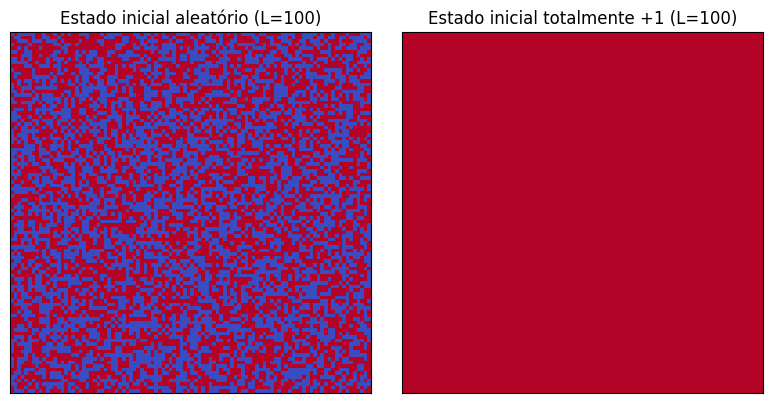

In [ ]:
# Função begin_lattice - Gera uma rede LxL, no plot obsrvamos os spins dependendo do tipo escolhido

# Parâmetros (explícitos)
L = 100
seed = 123

lat_random = begin_lattice(L=L, tipo="random", seed=seed)
lat_up     = begin_lattice(L=L, tipo="up",     seed=seed)

fig, ax = plt.subplots(1, 2, figsize=(8,4))
im0 = ax[0].imshow(lat_random, cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_title(f"Estado inicial aleatório (L={L})")
ax[0].set_xticks([]); ax[0].set_yticks([])
im1 = ax[1].imshow(lat_up, cmap="coolwarm", vmin=-1, vmax=1)
ax[1].set_title(f"Estado inicial totalmente +1 (L={L})")
ax[1].set_xticks([]); ax[1].set_yticks([])
plt.tight_layout(); plt.show()

Acima observamos o comportamento dos spins para rede L=100.

**Física do gráfico:** Cada célula é um spin $s_{ij}=\pm 1$. O estado "random" imita alta T(desordem), enquanto o estado "up" imita baixo T(ordem), com todos up (poderia também ser todos down).

**B) Dinâmica de Metrópolis: magnetização e energia vs. sweeps**

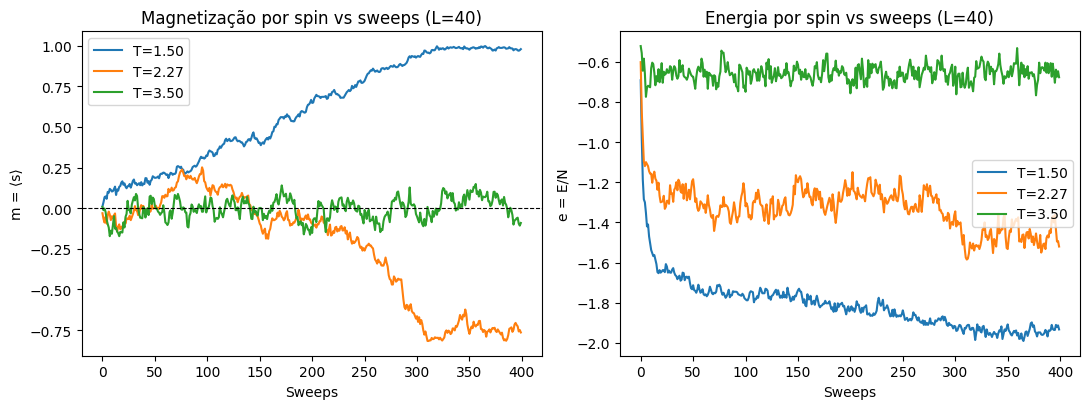

In [ ]:
# Função metropolis_sweep, magnetization e total_energe

# Parâmetros de simulação (explícitos)
L = 40
N_sweeps = 400
T_list = [1.50, 2.27, 3.50]   # <Tc, ~Tc, >Tc
J = 1.0
H = 0.0
seed = 42

fig, axs = plt.subplots(1, 2, figsize=(11,4.2))

for T in T_list:
    np.random.seed(seed)
    lat = begin_lattice(L=L, tipo="random", seed=seed)
    mags, enes = [], []
    for _ in range(N_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)
        mags.append(magnetization(lattice=lat))
        enes.append(total_energe(lattice=lat, J=J, H=H) / (L*L))

    axs[0].plot(mags, label=f"T={T:.2f}")
    axs[1].plot(enes, label=f"T={T:.2f}")

axs[0].axhline(0, color="k", lw=0.8, ls="--")
axs[0].set_xlabel("Sweeps"); axs[0].set_ylabel("m = ⟨s⟩")
axs[0].set_title(f"Magnetização por spin vs sweeps (L={L})")
axs[0].legend()

axs[1].set_xlabel("Sweeps"); axs[1].set_ylabel("e = E/N")
axs[1].set_title(f"Energia por spin vs sweeps (L={L})")
axs[1].legend()

plt.tight_layout(); plt.show()

Acima observamos o comportamento da magnetização e da energia por spin para três valores de temperatura. Sweeps representa os passos de monte carlo (após tentar flipar a rede L^2 vezes ).

**Física do gráfico:** Para T abaixo de $T_c$ (curva azul) observamos que a magnetização tende a ir para um extremo, nesse caso o estado +1, e todos os spins ficam ordenados.

Para T acima de $T_c$ (curva verde) observamos que a magnetização flutua em torno de 0, também como esperado, indicando que a rede se mantem no estado de desordem devido a alta temperatura fornecida ao sistema.

Por fim, para T próximo a $T_c$ observamos flutuações grandes e lentas pos os domínios de +1 e -1 competem entre si e a magnetização flutua mais fortemente.

Já no gráfico da energia observamos o comportamento claro da energia por spin aumentando conforme a temperatura da rede (após estabilizar).



**C) “Fotos” da evolução: formação de domínios vs desordem**

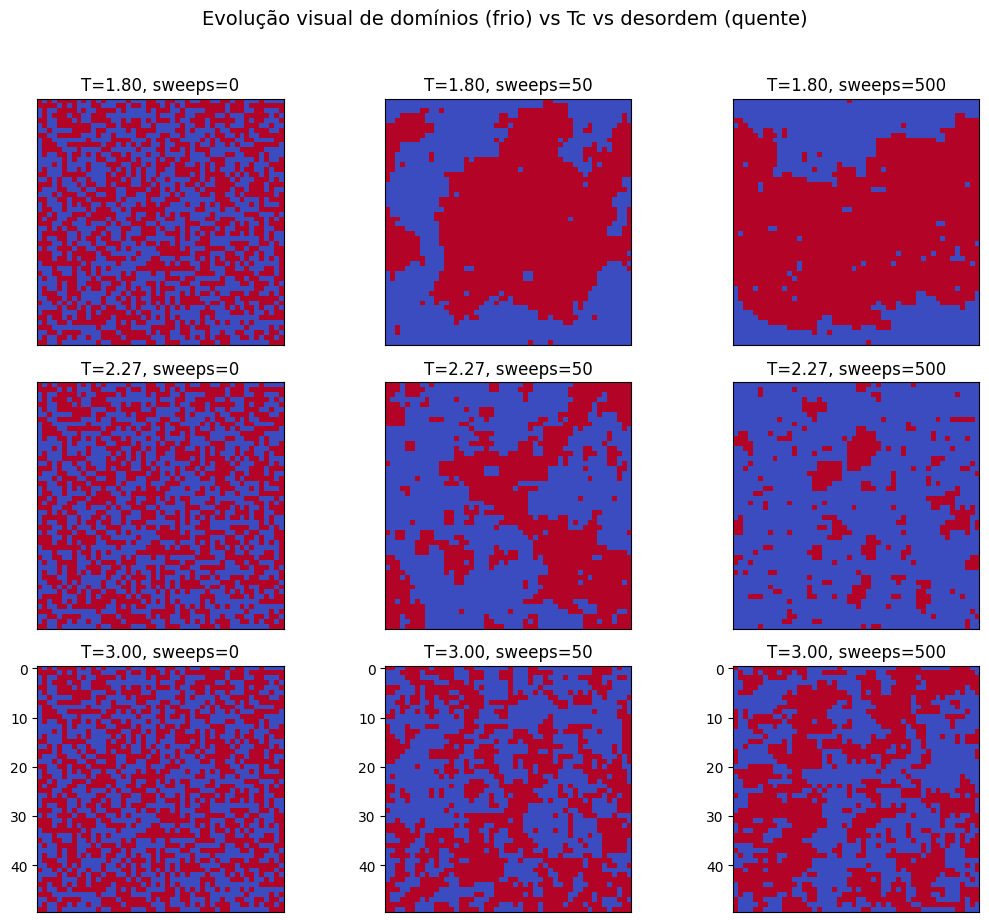

In [ ]:
def run_and_snapshots(L, T, n_sweeps_list, *, seed, J=1.0, H=0.0, tipo="random"):
    np.random.seed(seed)
    lat = begin_lattice(L=L, tipo=tipo, seed=seed)
    snaps = []
    sweep_count = 0
    for target in n_sweeps_list:
        while sweep_count < target:
            metropolis_sweep(lattice=lat, T=T, J=J, H=H)
            sweep_count += 1
        snaps.append(lat.copy())
    return snaps

# Parâmetros (explícitos)
L = 50
J = 1.0
H = 0.0
seed = 7
times = [0, 50, 500]   # sweeps-alvo para “fotografar”

snaps_cold = run_and_snapshots(L=L, T=1.80, n_sweeps_list=times, seed=seed, J=J, H=H, tipo="random")
snaps_Tc = run_and_snapshots(L=L, T=2.27, n_sweeps_list=times, seed=seed, J=J, H=H, tipo="random")
snaps_hot  = run_and_snapshots(L=L, T=3.00, n_sweeps_list=times, seed=seed, J=J, H=H, tipo="random")

fig, axes = plt.subplots(3, len(times), figsize=(1.8*len(times)*2, 9))
for j, t in enumerate(times):
    axes[0, j].imshow(snaps_cold[j], cmap="coolwarm", vmin=-1, vmax=1)
    axes[0, j].set_title(f"T=1.80, sweeps={t}")
    axes[0, j].set_xticks([]); axes[0, j].set_yticks([])
    axes[1, j].imshow(snaps_Tc[j], cmap="coolwarm", vmin=-1, vmax=1)
    axes[1, j].set_title(f"T=2.27, sweeps={t}")
    axes[1, j].set_xticks([]); axes[1, j].set_yticks([])
    axes[2, j].imshow(snaps_hot[j], cmap="coolwarm", vmin=-1, vmax=1)
    axes[2, j].set_title(f"T=3.00, sweeps={t}")
    axes[2, j].set_xticks([]); axes[1, j].set_yticks([])
plt.suptitle("Evolução visual de domínios (frio) vs Tc vs desordem (quente)", y=1.02, fontsize=14)
plt.tight_layout(); plt.show()

No gráfico acima observamos como os domínios crescem para dois diferentes de temperatura, uma abaixo da temperatura crítica (frio) e outro acima (quente).

**Física dos gráficos:** Observamos que para T=1.8 (frio) o domínio cresce com os passos de monte carlo e que para muitos sweeps esperamos que a rede termalize para um domínio único (nesse caso inteiramente vermelho).

Já para T=2.27 (Temperatura crítica) notamos que existem blocos de spins que não dominam o que representa as flutuações estatística observadas.

Por fim, para T=3.00 (quente) observamos que mesmo para muitos sweeps a rede continua no estado desordem (mesmo que os domínio pareçam crescer um pouco), para temperaturas mais altas essa desordem fica ainda mais evidente.

**D) Histogramas de magnetização: duas fases vs fase única**

Observando o gráfico acima notamos que é necessário primeiramente termalizar a rede em alguma temperatura para apenas depois coletar os dados. Dessa forma, o gráfico abaixo demonstra a distribuição da magnetização após a termalização da rede

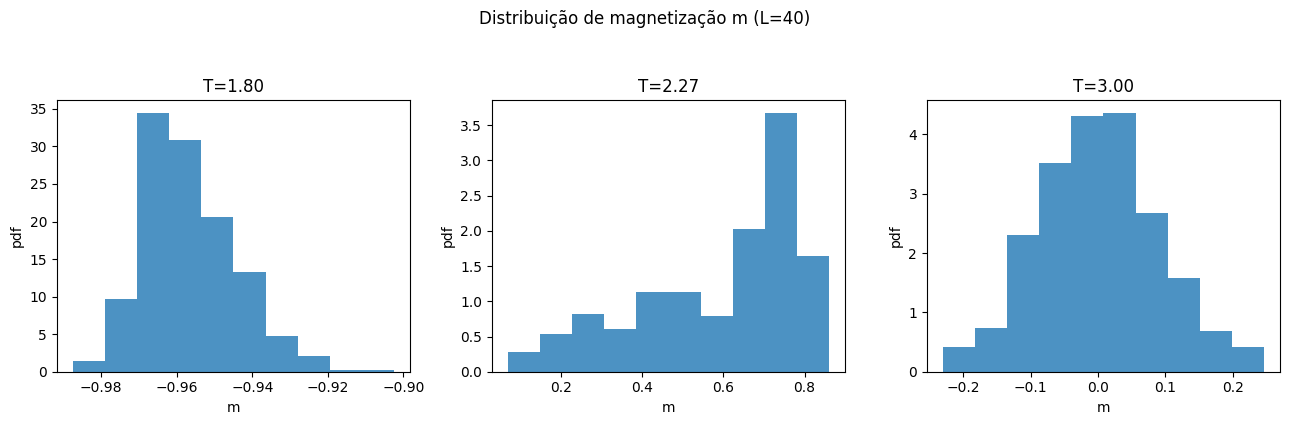

In [ ]:
# Comportamento da magnetização com

# Parâmetros (explícitos)
L = 40
T_set = [1.80, 2.27, 3.00]
J = 1.0
H = 0.0
seed = 2024
n_therm_sweeps = 300
n_meas_sweeps = 2000
sample_every = 5

fig, axs = plt.subplots(1, len(T_set), figsize=(13,4))

for ax, T in zip(axs, T_set):
    np.random.seed(seed)
    lat = begin_lattice(L=L, tipo="random", seed=seed)

    # termaliza
    for _ in range(n_therm_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)

    # mede
    m_samples = []
    for sweep in range(n_meas_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)
        if sweep % sample_every == 0:
            m_samples.append(magnetization(lattice=lat))

    ax.hist(m_samples, density=True, alpha=0.8)
    ax.set_title(f"T={T:.2f}")
    ax.set_xlabel("m"); ax.set_ylabel("pdf")

plt.suptitle(f"Distribuição de magnetização m (L={L})", y=1.05)
plt.tight_layout(); plt.show()


Acima vemos a distribuição da magnetização por um histograma em 3 diferentes temperaturas, abaixo de $T_c$, próximo e acima.

**Física dos gráficos:** Para T pequeno (frio), a magnetização tende a se alinhar com um dos campos e observamos que após a termalização a magnetização se encontra sempre concentrada próximo de -1, como esperado, observamos uma quebra espontânea de simetria, como já observados nos outros gráficos.

Para T grande (quente), a magnetização fica em torno de 0, após termailizada a rede, também como esperado, representando a fase paramagnética (desordem do spin).

Por fim, para T próximo de $T_c$ observamos que o valor de magnetização não tem um valor muito definido pois temos um estado de flutuações críticas, mesmo após a termalização da rede

**E) Tabela rápida (média no regime estacionário)**

In [ ]:
# Parâmetros (explícitos)
L = 40
J = 1.0
H = 0.0
seed = 10
T_values = [1.50, 2.10, 2.27, 2.40, 3.00]
n_therm_sweeps = 400
n_meas_sweeps = 1500
sample_every = 5

rows = []
for T in T_values:
    np.random.seed(seed)
    lat = begin_lattice(L=L, tipo="random", seed=seed)

    # termaliza
    for _ in range(n_therm_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)

    # mede
    m_list, e_list = [], []
    for sweep in range(n_meas_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)
        if sweep % sample_every == 0:
            m_list.append(abs(magnetization(lattice=lat)))
            e_list.append(total_energe(lattice=lat, J=J, H=H) / (L*L))

    # média das últimas 50 amostras (estado estacionário)
    tail = 50 if len(m_list) >= 50 else len(m_list)
    m_abs_mean = float(np.mean(m_list[-tail:]))
    e_mean     = float(np.mean(e_list[-tail:]))

    rows.append({"T": T, "⟨|m|⟩": m_abs_mean, "⟨e⟩": e_mean})

df_summary = pd.DataFrame(rows).sort_values("T").reset_index(drop=True)
print(df_summary.to_string(index=False))


   T    ⟨|m|⟩      ⟨e⟩
1.50 0.987525 -1.95375
2.10 0.875225 -1.66695
2.27 0.665025 -1.43140
2.40 0.406225 -1.22235
3.00 0.060625 -0.81680


O código acima serve para observar como a energia e a magnetização evoluem com a temperatura após a termalização e tomando a média de um sample de dados com a rede termalizada.

**Física da tabela:** Notamos que a magntização cai com T e cruza próximo de $T_c\approx 2.27 $, em outras palavras, após $T_c$ a magnetização absoluta cai mais rapidamente para 0. Isso evidencia a passagem da fase com quebra de simetria (antes de T_C) para a fase com simetria quebrada após $T_c$.

Do mesmo modo observamos o comportamento identico da energia por spin. Conforme aumentamos a temperatura a energia cresce suavente com T, devido ao ganho de eneriga pelo sistema, o que também é esperado.

**F) Checagem de consistência da energia total**

In [ ]:
# Parâmetros (explícitos)
L = 20
J = 1.0
H = 0.3
seed = 777
T = 2.0
n_sweeps = 50

np.random.seed(seed)
lat = begin_lattice(L=L, tipo="random", seed=seed)
for _ in range(n_sweeps):
    metropolis_sweep(lattice=lat, T=T, J=J, H=H)

# energia via sua função
E_func = total_energe(lattice=lat, J=J, H=H)

# energia via fórmula separando "ligações" e "campo"
N = L*L
# soma de s_i s_j para cada par de vizinhos (contagem única!)
pair_sum = 0.0
for i in range(L):
    for j in range(L):
        s = lat[i,j]
        pair_sum += s*lat[(i+1)%L, j] + s*lat[i, (j+1)%L]  # só direita e baixo
E_pairs = -J * pair_sum
E_field = -H * np.sum(lat)
E_check = E_pairs + E_field

print(f"E_total pela função: {E_func:.6f}")
print(f"E_total check (pares + campo): {E_check:.6f}")

E_total pela função: -819.000000
E_total check (pares + campo): -819.000000


A função acima serve apenas para verificarmos se de fato a energia está de acordo com a fórmula feita no código, que evita a contagem dupla de eneriga pelos pares.

**G) Checagem Física para H $\neq$ 0**

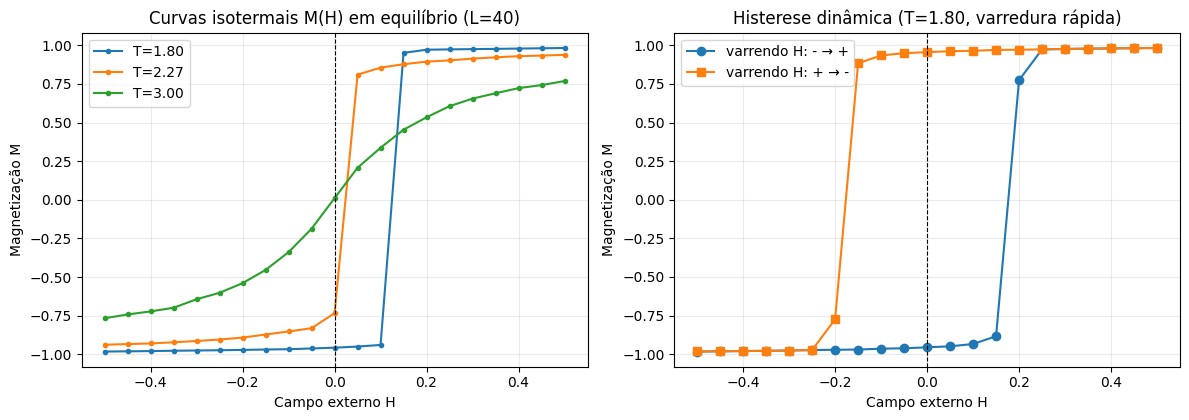

In [ ]:
# --- M(H) em equilíbrio + histerese não-equilíbrio (Dia 1, H != 0) ---

import numpy as np
import matplotlib.pyplot as plt

# ===== Parâmetros globais (explícitos) =====
L = 40
J = 1.0
seed = 123

# Grelha de campo e temperaturas
H_values_eq = np.linspace(-0.5, 0.5, 21)   # para curvas de equilíbrio
T_list_eq   = [1.80, 2.27, 3.00]          # <Tc, ~Tc, >Tc

# Termalização e medidas para o caso “equilíbrio”
n_therm_sweeps_eq   = 400
n_meas_sweeps_eq    = 1000
sample_every_eq     = 10

# Para histerese (deliberadamente “fraco” p/ mostrar loop)
T_hyst               = 1.80
H_values_hyst_up     = np.linspace(-0.5, 0.5, 21)
H_values_hyst_down   = np.linspace( 0.5,-0.5, 21)
n_therm_sweeps_hyst  = 80     # poucas iterações por passo de H
n_meas_sweeps_hyst   = 200
sample_every_hyst    = 5

# ===== Função auxiliar: estima M para um dado (T, H) =====
def estimate_M_at(L, T, H, *,
                  n_therm_sweeps, n_meas_sweeps, sample_every,
                  J=1.0, seed=None, start_lattice=None):
    if seed is not None:
        np.random.seed(seed)
    if start_lattice is None:
        lat = begin_lattice(L=L, tipo="random", seed=seed)
    else:
        lat = start_lattice.copy()

    # termaliza em (T,H)
    for _ in range(n_therm_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)

    # mede magnetização assinada (resposta ao campo)
    m_list = []
    for sweep in range(n_meas_sweeps):
        metropolis_sweep(lattice=lat, T=T, J=J, H=H)
        if sweep % sample_every == 0:
            m_list.append(magnetization(lattice=lat))

    M = float(np.mean(m_list))
    return M, lat  # retorna a última lattice para usar como “warm start”

# ===== (A) Curvas M(H) em equilíbrio para 3 temperaturas =====
fig, axs = plt.subplots(1, 2, figsize=(12,4.3))

for T in T_list_eq:
    # “warm start” progressivo em H: acelera a convergência mantendo equilíbrio
    M_eq = []
    lat_curr = begin_lattice(L=L, tipo="random", seed=seed)
    for H in H_values_eq:
        M, lat_curr = estimate_M_at(
            L=L, T=T, H=H,
            n_therm_sweeps=n_therm_sweeps_eq,
            n_meas_sweeps=n_meas_sweeps_eq,
            sample_every=sample_every_eq,
            J=J, seed=seed, start_lattice=lat_curr
        )
        M_eq.append(M)
    axs[0].plot(H_values_eq, M_eq, marker="o", ms=3, label=f"T={T:.2f}")

axs[0].axvline(0.0, color="k", ls="--", lw=0.8)
axs[0].set_xlabel("Campo externo H")
axs[0].set_ylabel("Magnetização M")
axs[0].set_title("Curvas isotermais M(H) em equilíbrio (L=40)")
axs[0].legend()
axs[0].grid(alpha=0.25)

# ===== (B) Loop de histerese (não-equilíbrio) em T<Tc =====
# Subimos H com pouca termalização por passo e depois descemos.
# Isso enfatiza a dependência do histórico (metastabilidade).
M_up, M_down = [], []

lat_curr = begin_lattice(L=L, tipo="random", seed=seed)
for H in H_values_hyst_up:
    M, lat_curr = estimate_M_at(
        L=L, T=T_hyst, H=H,
        n_therm_sweeps=n_therm_sweeps_hyst,
        n_meas_sweeps=n_meas_sweeps_hyst,
        sample_every=sample_every_hyst,
        J=J, seed=seed, start_lattice=lat_curr
    )
    M_up.append(M)

# agora descendo H (começa da última lattice da subida)
for H in H_values_hyst_down:
    M, lat_curr = estimate_M_at(
        L=L, T=T_hyst, H=H,
        n_therm_sweeps=n_therm_sweeps_hyst,
        n_meas_sweeps=n_meas_sweeps_hyst,
        sample_every=sample_every_hyst,
        J=J, seed=seed, start_lattice=lat_curr
    )
    M_down.append(M)

axs[1].plot(H_values_hyst_up,   M_up,   "o-", label="varrendo H: - → +")
axs[1].plot(H_values_hyst_down, M_down, "s-", label="varrendo H: + → -")
axs[1].axvline(0.0, color="k", ls="--", lw=0.8)
axs[1].set_xlabel("Campo externo H")
axs[1].set_ylabel("Magnetização M")
axs[1].set_title(f"Histerese dinâmica (T={T_hyst:.2f}, varredura rápida)")
axs[1].legend()
axs[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()

Os gráficos acima demonstram o comportamento da magnetização para 21 pontos diferentes de H. O valor calculado da magnetização é após a rede termalizada em uma certa temperatura, tomando média de um sample de dados para todos os valores de H. O gráfico da direita é uma média após uma situação de equilíbrio enquanto o da esquerda a rede ainda não se encontra totalmente termalizada.

**Física dos gráficos:**

**1. Gráfico da direita - Termializado**

Diferente do caso de campo nulo, observamos claramente pelo gráfico termalizado,que independemente da temperatura do sistema, os spins tendem sempre a se alinhar para a direção do campo magnético. Para campos muito negativos os spins sempre se encontram alinhado em -1 e para campos positivos os spins se alinham em -1.

Para temperatura abaixo de $T_c$ (curva azul), esperamos que a rede já tenda automaticamente a escolher uma direção preferencial, por ser uma temperatura relacionada a quebra de simetria da rede. O que observamos é exatamente isso, quando o sinal de campo muda rapidamente a rede salta para o spin oposto e fica totalmente alinhada.

Para temperatura próxima a $T_c$ (curva laranja) a inclinação fica muito grande quando H=0, isso já é um índicio da suceptibilidade $\chi = \partial M/\partial H$ ficando grande, o que é esperado, por ser um dos marcus da tempeartura crítica (em campo nulo a suceptibilidade é muito grande em $T_C$, pois qualquer variação de campo faz com que todos os spins se linha e um dos blocos domine).

Por fim, para temperaturas maiores que $T_C$ (curva verde) observamos uma curva muito mais suave, pois os spins não tem nenhuma direção preferencial sem o campo e portanto evoluem mais lentamente com o campo variando. A temperatura alta permite que estados continuem desalinhados mesmo com a presença do campo e por isso observamos a curva mais suave. Próxima o campo próximo de 0 notamos um comportamento quase linear, também como esperado, uma vez que o valor da magnetização sem o campo já é tendencioso ao 0, para T grande.

**2. Gráfico da esquerda - Não termalizado**
O gráfico da esquerda ilustra o comportamendo quando não termalizamos a rede, para campos altos e baixo o sistema fica preso em domínios e não obsrevamos um comportamento crescente como antes, isso serve apenas para ilustrar a necessidade de termalizar a rede e evitar a dependência do histórico (poucos sweeps).

**Conclusões finais para do dia 1:**

1. Implematado, testado e discutido o "motor" metrópolis.

2. Vimos a quebra de simetria para $T < T_c$ (alinhamento dos spins, m$\neq 0$)  e a volta da simetria para $T> T_c$ (desordem dos spins, $m→0$)

3. Vimos como a evolução dos domínios ocorrem para T baixo e T alto e como para temperaturas próximas a $T_c$ temos ilhas de spins e flutuações maiores da magnetização

4. Constriuimos os histogramas de m, que diferenciam mais claramente a fase ferromagnética (spins alinhados) da fase paramagnética (spins desalinhados)

5. Por fim checamos a consistência da eneriga total calculada e observamos o comportamento para diferentes valores de campo, onde concluímos que o campo influencia a direção dos spins independentemente da temperatura e que o comportamento para o campo próximo de 0 que nos diz se estamos próximos, abaixos ou acima de $T_c$ evidenciando o comportamendo da susceptibilidade.

Com isso para o dia 2 nossa tarefa é encontrar os parâmetros de interesse como o calor específico, cumulante de blinder, energia, susceptibilidade e outros e verificar como esses parâmetros mudam com a temperatura. Isso é o começo para o algoritmo de wolf que iremos implementar.





### Dia 2 - Preparação para o Wolf e variáveis termodinâmicos

Nessa parte do código encontramos as variáveis termodinâmicas de interesse para serem analisadas

In [ ]:
T_c_known = 2.26918531421  # Tc do Ising 2D (J=1, kB=1)
# Temperatura conhecida do Ising 2D


**A) Aquecimento/termalização da rede e amostragem em uma temperatura**

T=2.300 | ⟨|M|⟩=0.5370 | χ=149.312 | C=2.197 | U=0.538 | ⟨E⟩/N=-1.3623


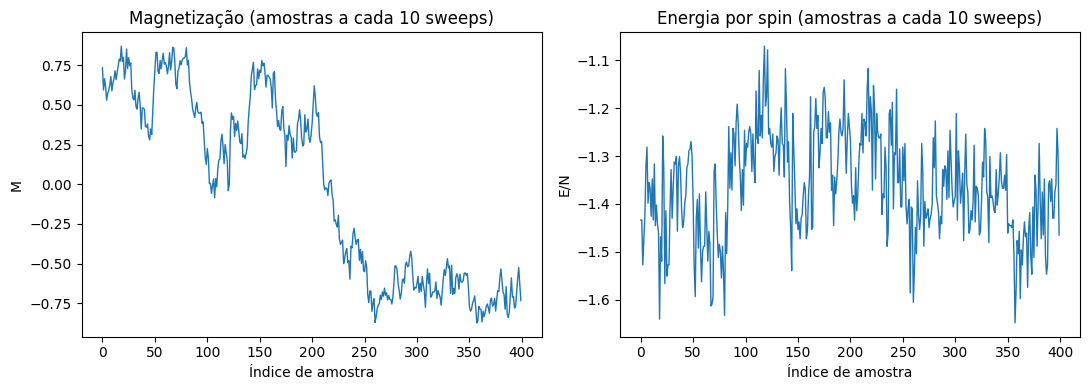

In [ ]:
# Parâmetros explícitos
L = 32
T = 2.30 # Temperatura próxima a T_c
J = 1.0
H = 0.0
seed = 2025

n_therm_sweeps = 1500
n_sweeps       = 4000
sample_every   = 10

# --- constrói e termaliza ---
np.random.seed(seed)
lattice = begin_lattice(L=L, tipo="random", seed=seed)
run_equilibrate(lattice=lattice, T=T, n_therm_sweeps=n_therm_sweeps, J=J, H=H)

# --- mede séries M(t), E(t) ---
M_series, E_series = measure_observables(
    lattice=lattice, T=T, n_sweeps=n_sweeps, sample_every=sample_every, J=J, H=H
)
M_series = np.asarray(M_series)
E_series = np.asarray(E_series)

# --- observáveis termodinâmicos nesse T ---
M_abs, chi, C, U, E_mean = compute_observables(M_samples=M_series, E_samples=E_series, T=T, L=L)

print(f"T={T:.3f} | ⟨|M|⟩={M_abs:.4f} | χ={chi:.3f} | C={C:.3f} | U={U:.3f} | ⟨E⟩/N={E_mean/(L*L):.4f}")

# --- plots temporais (ao longo dos sweeps, i.e. passos de Montecarlo) ---
fig, axs = plt.subplots(1, 2, figsize=(11,4))
axs[0].plot(M_series, lw=1.0)
axs[0].set_title(f"Magnetização (amostras a cada {sample_every} sweeps)")
axs[0].set_xlabel("Índice de amostra"); axs[0].set_ylabel("M")

axs[1].plot(E_series/(L*L), lw=1.0)
axs[1].set_title(f"Energia por spin (amostras a cada {sample_every} sweeps)")
axs[1].set_xlabel("Índice de amostra"); axs[1].set_ylabel("E/N")

plt.tight_layout(); plt.show()


No gráfico acima observamos as séries temporais (evolução por passos de montecarlo) da magnetização (M) e da energia por spin (E/N) após a termalização do sistema a uma temperatura próxima a tempeartura crítica (T=2.3).

**Física dos gráficos e parâmetros:** Para a tempeartura próxima de $T_c$ notamos dois fatos importantes dos gráficos.

1.   Existência de grandes flutuações na magnetização média do sistema
2.   Existência de grandes flutuações na energia por spin do sistema

Isso acontece porque, como já discutido anteriormente, próximo a $T_c$ o sistema está "instável" e qualquer variação de spin ou campo externo faz com que um dos blocos de spin up ou down dominem (se a temperatura abaixar). Esse fato é refletido nos observáveis físicos mostrados acima, tanto suscepitbilidade $χ$ quando o valor específico C crescem muito próximo a temperatura crítica, evidenciando as grandes flutuações do sistema nessa temperatura. A ideia para encontrar $T_c$ e os expoentes críticos do ising 2D é justamentee feita a partir dos picos desses observáveis físicos relacionados as grandes flutuações do sistema.  

Para ficar mais claro devemos verificar como esses observáveis mudam para diversas temperaturas e seus comportamentos próximos a $T_c$ que reflitam essas grandes flutuações observadas



**B) Varredura em temperatura: $⟨|M|⟩(T), χ(T), C(T), U_L(T), ⟨E⟩(T)$**

In [ ]:
# Parâmetros explícitos da varredura
L = 24
J = 1.0
H = 0.0
seed = 17

T_values = np.linspace(1.6, 3.2, 21)   # passo 0.08
n_therm   = 1200
n_sweeps  = 3000
sample_every = 10
n_resamples  = 400  # bootstrap leve para barras de erro

results = scan_temperature(
    L=L, T_values=T_values, n_therm=n_therm, n_sweeps=n_sweeps, sample_every=sample_every,
    seed=seed, J=J, H=H, tipo="random", n_resamples=n_resamples
)
df = pd.DataFrame(results).sort_values("T").reset_index(drop=True)
df.head(20)

/tmp/ipython-input-3444058555.py:333: RuntimeWarning: invalid value encountered in divide
  U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)


,T,M_abs,dM_abs,chi,dchi,C,dC,U,dU,E_mean,dE
0,1.60,0.979826,0.000562,0.035969,0.409924,0.241596,1.646120,0.666529,5.551115e-18,-1110.626667,1.128768
1,1.68,0.971366,0.000806,0.062276,0.526011,0.321957,1.832508,0.666412,1.468687e-17,-1096.080000,1.310004
2,1.76,0.963785,0.000910,0.086115,0.575598,0.389280,1.774079,0.666296,2.884444e-17,-1081.986667,1.606261
3,1.84,0.951713,0.001096,0.122854,0.684295,0.479104,1.973479,0.666100,4.116817e-17,-1061.493333,1.645177
4,1.92,0.935532,0.001701,0.236662,0.909690,0.653120,2.192291,0.665499,6.206335e-17,-1038.120000,2.187515
5,2.00,0.911088,0.002168,0.373491,1.034086,0.720390,2.089528,0.664705,9.404185e-17,-1004.093333,2.363615
6,2.08,0.881262,0.002894,0.695929,1.395429,1.018286,2.110754,0.662651,1.202172e-16,-968.746667,2.966574
7,2.16,0.841794,0.003395,0.977578,1.546936,1.088673,2.068466,0.660201,9.836601e-17,-927.640000,3.016038
8,2.24,0.732836,0.008788,6.689972,2.558630,1.593018,2.268125,0.629794,9.121413e-17,-859.160000,3.964581
9,2.32,0.552014,0.012711,86.665316,3.210332,1.727219,2.125660,0.537280,NaN,-777.680000,4.248811


Acima temos o código que encontra  os valores de magnetização, susceptibilidade, calor específico e energia média da rede para diversas temperaturas, com seus respectivos erros.

Esses dados foram tomados para uma longa variação de temperatura para podermos observar melhor o comportamento ao longo do regime frio e quente.

Dessa forma o próximo passo é observá-los em um gráfico para podermos realizar a interpretação física desses parâmetros termodinâmicos

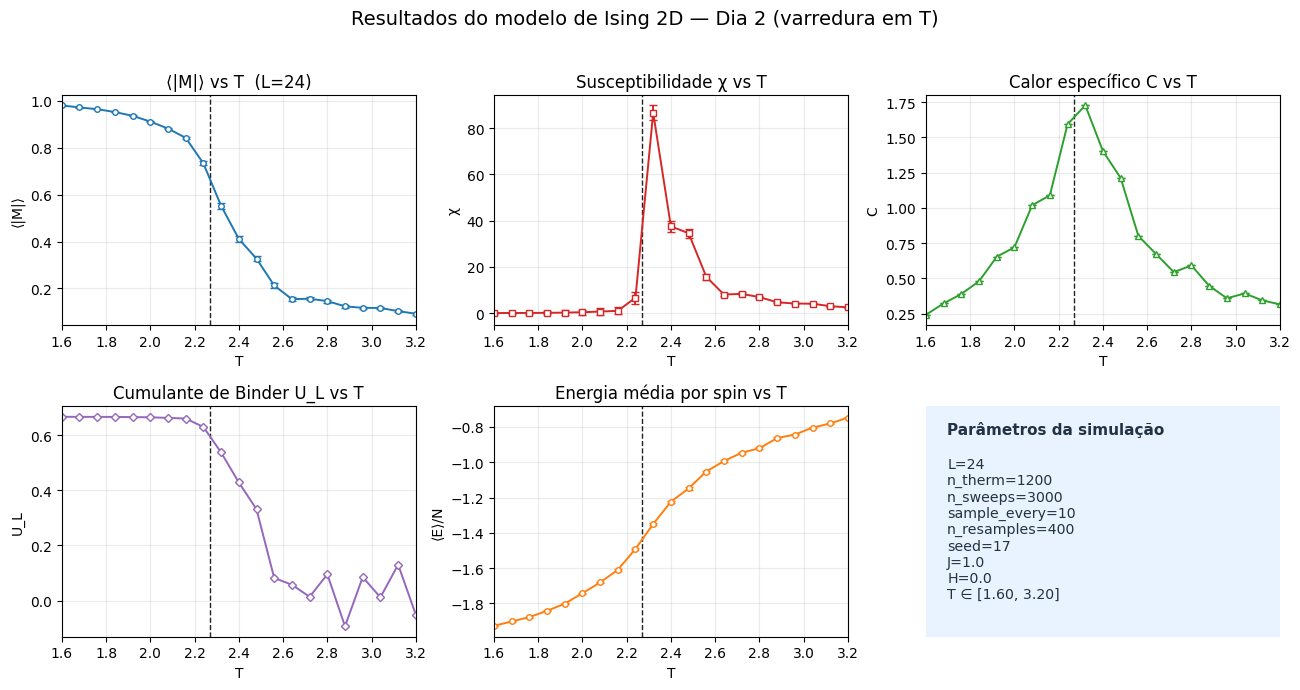

In [ ]:
import matplotlib.patches as patches


# paleta (paletas de cores para cada gráfico)
colors = {
    "M_abs": "#1f77b4",  # azul
    "chi":   "#d62728",  # vermelho
    "C":     "#2ca02c",  # verde
    "U":     "#9467bd",  # roxo
    "E":     "#ff7f0e",  # laranja
    "Tc":    "#222222",  # preto para a linha
    "card_fg": "#234",   # texto do cartão
    "card_bg": "#e9f2ff",# fundo do cartão
    "card_edge": "#4c72b0"
}

fig, axs = plt.subplots(2, 3, figsize=(13, 7))
axs = axs.ravel()

# limites x baseados na grade
tmin, tmax = float(df["T"].min()), float(df["T"].max())

# |M|
axs[0].errorbar(df["T"], df["M_abs"], yerr=df["dM_abs"], fmt="o-",
                ms=4, lw=1.4, capsize=3, color=colors["M_abs"], mfc="white")
axs[0].axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
axs[0].set_title(f"⟨|M|⟩ vs T  (L={L})")
axs[0].set_xlabel("T"); axs[0].set_ylabel("⟨|M|⟩")
axs[0].grid(alpha=0.25)
axs[0].set_xlim(tmin, tmax)

# χ
axs[1].errorbar(df["T"], df["chi"], yerr=df["dchi"], fmt="s-",
                ms=4, lw=1.4, capsize=3, color=colors["chi"], mfc="white")
axs[1].axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
axs[1].set_title("Susceptibilidade χ vs T")
axs[1].set_xlabel("T"); axs[1].set_ylabel("χ")
axs[1].grid(alpha=0.25)
axs[1].set_xlim(tmin, tmax)

# C
axs[2].errorbar(df["T"], df["C"], yerr=0 , fmt="^-", #df["dC"] caso queira erro em C
                ms=4, lw=1.4, capsize=3, color=colors["C"], mfc="white")
axs[2].axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
axs[2].set_title("Calor específico C vs T")
axs[2].set_xlabel("T"); axs[2].set_ylabel("C")
axs[2].grid(alpha=0.25)
axs[2].set_xlim(tmin, tmax)

# U
axs[3].errorbar(df["T"], df["U"], yerr=df["dU"], fmt="D-",
                ms=4, lw=1.4, capsize=3, color=colors["U"], mfc="white")
axs[3].axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
axs[3].set_title("Cumulante de Binder U_L vs T")
axs[3].set_xlabel("T"); axs[3].set_ylabel("U_L")
axs[3].grid(alpha=0.25)
axs[3].set_xlim(tmin, tmax)

# E/N
axs[4].errorbar(df["T"], df["E_mean"]/(L*L), yerr=df["dE"]/(L*L), fmt="o-",
                ms=4, lw=1.4, capsize=3, color=colors["E"], mfc="white")
axs[4].axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
axs[4].set_title("Energia média por spin vs T")
axs[4].set_xlabel("T"); axs[4].set_ylabel("⟨E⟩/N")
axs[4].grid(alpha=0.25)
axs[4].set_xlim(tmin, tmax)

# Cartão de parâmetros
axs[5].set_axis_off()
# patch arredondado ocupando boa parte do eixo
box = patches.FancyBboxPatch(
    (0.03, 0.05), 0.94, 0.90,  # (x,y), width, height em coords do eixo
    boxstyle="round,pad=0.6,rounding_size=0.04",
    linewidth=1.2, edgecolor=colors["card_edge"], facecolor=colors["card_bg"],
    transform=axs[5].transAxes
)
axs[5].add_patch(box)
# título do cartão
axs[5].text(0.06, 0.88, "Parâmetros da simulação", transform=axs[5].transAxes,
            fontsize=11, fontweight="bold", color=colors["card_fg"])
# conteúdo
param_text = (
    f"L={L}\n"
    f"n_therm={n_therm}\n"
    f"n_sweeps={n_sweeps}\n"
    f"sample_every={sample_every}\n"
    f"n_resamples={n_resamples}\n"
    f"seed={seed}\n"
    f"J={J}\n"
    f"H={H}\n"
    f"T ∈ [{tmin:.2f}, {tmax:.2f}]"
)
axs[5].text(0.06, 0.78, param_text, transform=axs[5].transAxes,
            fontsize=10.2, color=colors["card_fg"], va="top")

# anotação de Tc em todos (uma vez na figura)
fig.suptitle("Resultados do modelo de Ising 2D — Dia 2 (varredura em T)", y=0.98, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

**Física dos gráficos:**  Em todos os gráficos a reta vertical preta representa o valor conhecido da temperatura crítica para esse modelo de ising 2D

1. $⟨|M|⟩(T):$ Notamos calramente pelo gráfico de curva azul o comportamento da magnetização absoluta (norma), para a fase quebrada os spins estão sempre alinhados e se encontram em +1 e para T grande, acima de $T_c$ a magnetização vai a 0, também como esperado e já demonstrado recuperando a simetria do sistema. Em $T_C$ notamos que a magnetização sofre uma grande queda, isso pode ser mais notado por $χ$ que está relacionados a essas flutuações da magnetização, ou também pode ser notado percebendo que $⟨|M|⟩$ tem um ponto de inflexão próximo a $T_c$.

2. $χ(T):$ Do mesmo modo, notamos que a susceptibilidade é praticamente 0 para valores altos e baixos de T na ausência de campo magnético. Entretanto, para a próximo a temperatura crítica a susceptibilidade apresenta um pico enorme, isso está relacionado no fundo as grandes flutuações da magnetização nessa temperatura, como já discutido, esse é o parâmetro físico que nos permite encontrar a temperatura crítica do sistema. Se quisermos um resultado mais preciso, precisariamos fazer uma malha mais fina de temperatura em torno de $T_c$ e é isso que iremos trabalhar nos próximos itens

3. $⟨E⟩/N(T):$ Já a energia média por spin, de forma parecida mais invertida da magnetização, cresce com a temperatura de maneira contínua (suave) com o crescimento de T, conforme esperado. Próximo a $T_c$ a energia apresenta, assim como a magnetização, um ponto de inflexão próximo a $T_C$, essa flutuação da energia nesse ponto é melhor expressada pelo calor específico, pois os mesmos está diretamente relacionado as flutuações de energia.

4. $C(T):$ O calor específico segue o mesmo comportamento de $\chi$, próximo a temperatura crítica do sistema ele tem um pico e portanto é o outro parâmetro importante desse modelo que está diretamente relacionado a temperatura crítica e que nos permite encontrá-la através de simulações. Observação: No código eu omiti os valores da barra de erro encontrados em C pois elas são muito grandes e isso faz com que o plot não fique bem visto, entretanto elas podem ser encontradas na tabela abaixo.

5. $U_L(T):$ Por fim, o cumulante de blinder é o terceiro parâmetro que também está diretamente ligada a transição do sistema e sua temperatura crítica. Na fase ordenada observamos que ele se mantém por volta de $U_L=2/3$ e na fase deserdenada (quebrada) passa a valer $U_L ≈ 0 $. Após o sistema atingir a temperatura crítica que essa variável passa a decair rapidamente e ela também será a chave para encontrar a temperatura crítica e expoentes críticos do modelo e reproduzir as imagens dos artigos escolhidos.







**C) Tabela de resultados obtidos**

In [ ]:
cols = ["T","M_abs","dM_abs","chi","dchi","C","dC","U","dU","E_mean","dE"]
print(df[cols].round(5).to_string(index=False))
# Opcional: salvar CSV
# df[cols].to_csv("day2_scan_L{L}.csv".format(L=L), index=False)

   T   M_abs  dM_abs      chi    dchi       C      dC        U  dU      E_mean      dE
1.60 0.97983 0.00056  0.03597 0.40992 0.24160 1.64612  0.66653 0.0 -1110.62667 1.12877
1.68 0.97137 0.00081  0.06228 0.52601 0.32196 1.83251  0.66641 0.0 -1096.08000 1.31000
1.76 0.96378 0.00091  0.08612 0.57560 0.38928 1.77408  0.66630 0.0 -1081.98667 1.60626
1.84 0.95171 0.00110  0.12285 0.68429 0.47910 1.97348  0.66610 0.0 -1061.49333 1.64518
1.92 0.93553 0.00170  0.23666 0.90969 0.65312 2.19229  0.66550 0.0 -1038.12000 2.18752
2.00 0.91109 0.00217  0.37349 1.03409 0.72039 2.08953  0.66470 0.0 -1004.09333 2.36362
2.08 0.88126 0.00289  0.69593 1.39543 1.01829 2.11075  0.66265 0.0  -968.74667 2.96657
2.16 0.84179 0.00339  0.97758 1.54694 1.08867 2.06847  0.66020 0.0  -927.64000 3.01604
2.24 0.73284 0.00879  6.68997 2.55863 1.59302 2.26812  0.62979 0.0  -859.16000 3.96458
2.32 0.55201 0.01271 86.66532 3.21033 1.72722 2.12566  0.53728 NaN  -777.68000 4.24881
2.40 0.41126 0.01255 37.54021 2.45194 1.402

Acima está a tabela com todos os valores obtidos no código e plotados no gráfico. Os erros foram feitos utilizando a função bootstrap

**D) Focus em torno de $T_c$: malha fina**

Para termos resultados melhor dos picos precisamos fazer uma rodagem bem próxima de $T_c$ e verificar como os parâmetros variam para podermos obter os verdadeiros picos

In [ ]:
# ====== MALHA FINA PERTO DE Tc: χ(T), C(T), U_L(T) (estético) ======

# --- paleta consistente com o bloco anterior ---
colors = {
    "chi":   "#d62728",  # vermelho
    "C":     "#2ca02c",  # verde
    "U":     "#9467bd",  # roxo
    "Tc":    "#222222",  # linha de Tc
}

# --- parâmetros explícitos da simulação refinada ---
L_refine          = 24
J_refine          = 1.0
H_refine          = 0.0
seed_refine       = 101

# janela estreita em torno de Tc
T_center          = T_c_known
dT_window         = 0.06          # meia-largura da janela
dT_step           = 0.004         # passo da grade
T_values_refine   = np.arange(T_center - dT_window,
                              T_center + dT_window + 1e-12,
                              dT_step)

n_therm_refine    = 1800
n_sweeps_refine   = 6000
sample_every_ref  = 12
n_resamples_ref   = 400

# --- roda varredura fina usando scan_temperature ---
df_ref = pd.DataFrame(scan_temperature(
    L=L_refine,
    T_values=T_values_refine,
    n_therm=n_therm_refine,
    n_sweeps=n_sweeps_refine,
    sample_every=sample_every_ref,
    seed=seed_refine,
    J=J_refine,
    H=H_refine,
    tipo="random",
    n_resamples=n_resamples_ref
)).sort_values("T").reset_index(drop=True)


/tmp/ipython-input-3444058555.py:333: RuntimeWarning: invalid value encountered in divide
  U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)


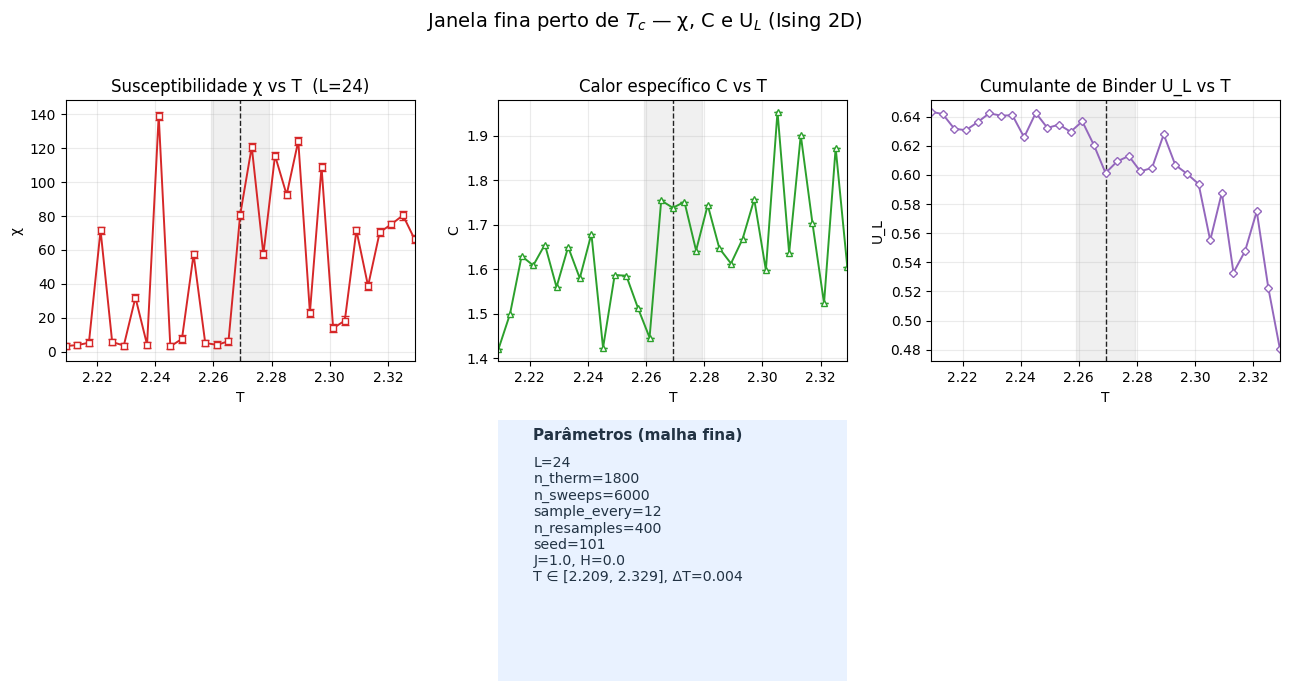

In [ ]:
# paleta (mesma do bloco anterior)
colors = {"chi": "#d62728", "C": "#2ca02c", "U": "#9467bd", "Tc": "#222222"}

# limites para o eixo x
tmin, tmax = float(df_ref["T"].min()), float(df_ref["T"].max())
# passo (robusto) da grade
dT_step = float(np.median(np.diff(df_ref["T"].values)))

fig, axs = plt.subplots(2, 3, figsize=(13, 7))
ax_chi, ax_C, ax_U = axs[0, 0], axs[0, 1], axs[0, 2]
ax_blankL, ax_card, ax_blankR = axs[1, 0], axs[1, 1], axs[1, 2]

# χ(T)
ax_chi.errorbar(df_ref["T"], df_ref["chi"], yerr=df_ref["dchi"],
                fmt="s-", ms=4, lw=1.4, capsize=3,
                color=colors["chi"], mfc="white")
ax_chi.axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
ax_chi.axvspan(T_c_known-0.01, T_c_known+0.01, color="k", alpha=0.06)
ax_chi.set_title(f"Susceptibilidade χ vs T  (L={L_refine})")
ax_chi.set_xlabel("T"); ax_chi.set_ylabel("χ")
ax_chi.grid(alpha=0.25); ax_chi.set_xlim(tmin, tmax)

# C(T)
ax_C.errorbar(df_ref["T"], df_ref["C"], yerr=0, #df_ref["dC"] Erro caso queira
              fmt="^-", ms=4, lw=1.4, capsize=3,
              color=colors["C"], mfc="white")
ax_C.axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
ax_C.axvspan(T_c_known-0.01, T_c_known+0.01, color="k", alpha=0.06)
ax_C.set_title("Calor específico C vs T")
ax_C.set_xlabel("T"); ax_C.set_ylabel("C")
ax_C.grid(alpha=0.25); ax_C.set_xlim(tmin, tmax)

# U_L(T)
ax_U.errorbar(df_ref["T"], df_ref["U"], yerr=df_ref["dU"],
              fmt="D-", ms=4, lw=1.4, capsize=3,
              color=colors["U"], mfc="white")
ax_U.axvline(T_c_known, color=colors["Tc"], ls="--", lw=1)
ax_U.axvspan(T_c_known-0.01, T_c_known+0.01, color="k", alpha=0.06)
ax_U.set_title("Cumulante de Binder U_L vs T")
ax_U.set_xlabel("T"); ax_U.set_ylabel("U_L")
ax_U.grid(alpha=0.25); ax_U.set_xlim(tmin, tmax)

# painéis laterais de baixo sem conteúdo
ax_blankL.axis("off")
ax_blankR.axis("off")

# cartão de parâmetros no meio da 2ª linha
ax_card.set_axis_off()
box = patches.FancyBboxPatch(
    (0.05, 0.05), 0.90, 0.90,
    boxstyle="round,pad=0.6,rounding_size=0.05",
    linewidth=1.1, edgecolor="#4c72b0", facecolor="#e9f2ff",
    transform=ax_card.transAxes
)
ax_card.add_patch(box)
ax_card.text(0.10, 0.92, "Parâmetros (malha fina)", transform=ax_card.transAxes,
             fontsize=11, fontweight="bold", color="#234")
param_text = (
    f"L={L_refine}\n"
    f"n_therm={n_therm_refine}\n"
    f"n_sweeps={n_sweeps_refine}\n"
    f"sample_every={sample_every_ref}\n"
    f"n_resamples={n_resamples_ref}\n"
    f"seed={seed_refine}\n"
    f"J={J_refine}, H={H_refine}\n"
    f"T ∈ [{tmin:.3f}, {tmax:.3f}], ΔT={dT_step:.3f}"
)
ax_card.text(0.10, 0.86, param_text, transform=ax_card.transAxes,
             fontsize=10.2, color="#234", va="top")

fig.suptitle("Janela fina perto de $T_c$ — χ, C e U$_L$ (Ising 2D)", y=0.98, fontsize=14)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

O gráfico acima demonstra que de fato a malha fina em torno de $T_c$ é necessária para observamos quando os parâmetros crescem e termos resultados mais precisos e compatíveis com os valores previstos teoricamente. Entretanto, ainda há alguns outliers nos gráficos acima, que ocorrem devido ao tamanho finito da rede e número finito dos passos de montecarlo feitos tanto para termalização quanto para tomarmos as medidas. Ainda assim, com essa simulação de 1 hora já observamos um bom resultado.

### Dia 3 - Estimativa de $T_c$ pela simulação e gráficos-guia (com Binder)

## Testes (Dia 1 e 2)

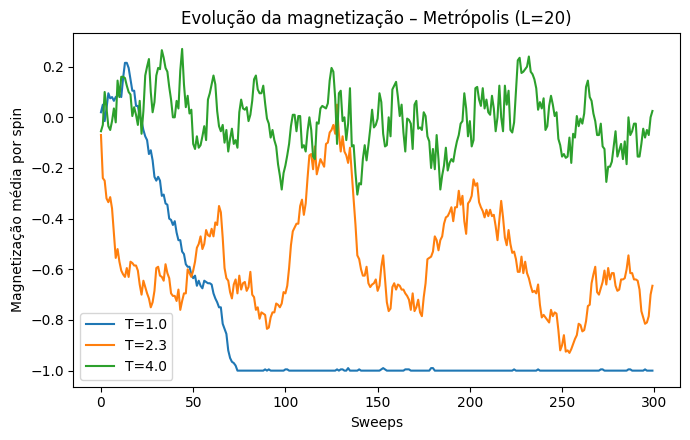

In [ ]:
# Testes com o que feito no dia 1 - Evolução da magnetização utilizando Metrópolis

# --- parâmetros ---
L = 20
T_list = [1.0, 2.3, 4.0]   # abaixo, perto (~Tc≈2.269), e bem acima de Tc
N_sweeps = 300
seed = 42

# gráfico: magnetização vs sweeps para diferentes T
plt.figure(figsize=(7,4.5))
for T in T_list:
    np.random.seed(seed)
    lat = begin_lattice(L, tipo="random")
    mags = []
    for _ in range(N_sweeps):
        metropolis_sweep(lat, T)
        mags.append(magnetization(lat))
    plt.plot(mags, label=f"T={T}")

plt.xlabel("Sweeps")
plt.ylabel("Magnetização média por spin")
plt.title("Evolução da magnetização – Metrópolis (L=20)")
plt.legend()
plt.tight_layout()
plt.show()

No gráfico acima já observamos o comportamento da magnetização para diferentes temperaturas. Para T baixo (abaixo da temperatura crítica 2.2, curva azul) a probabilidade de flipar o spin quando a diferença de energia é positiva é quase 0, isso faz com que os flips só ocorram para +1 ou -1, a depender dos vizinhos. Dessa foram toda a rede migra para um dos estados e ocorre uma quebra de simetria espontânea da rede, no gráfico acima para -1.

Já para altar temerapturas ( curva verde ), ficamos com um comportamento de flutuação em torno da magnetização 0, já que mesmo quando a diferença de energia é positiva o flip é aceito e assim o sistema mantém sua simetria, o que é esperado.

Na temperatura crítica (curva laranja) observamos um comportamento instável, a magnetização tende de forma mais lenda a um dos estados de spin e isso pode ser entendido como formando blocos (ilhas) de spins +1 ou -1 já que na temperatura crítica estamos justamente no caso que qualquer mudança de temperatura faz com que o sistema assuma um dos dois estados (curva azul).

Testes do dia 2, funções utilizadas e suas interpretações

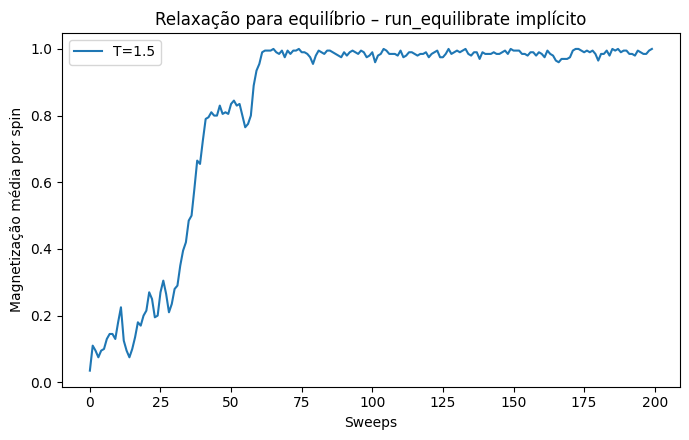

In [ ]:
# --- parâmetros ---
# Testando equilíbrio térmico (quantidade de sweeps necessários para o run_equilibrate)
L = 20
T = 1.5     # abaixo de Tc
N_sweeps = 200

lat = begin_lattice(L, tipo="random", seed=42)
mags = []

# acompanha evolução da magnetização sem equilibrar antes
for _ in range(N_sweeps):
    metropolis_sweep(lat, T)
    mags.append(magnetization(lat))

plt.figure(figsize=(7,4.5))
plt.plot(mags, label=f"T={T}")
plt.xlabel("Sweeps")
plt.ylabel("Magnetização média por spin")
plt.title("Relaxação para equilíbrio – run_equilibrate implícito")
plt.legend()
plt.tight_layout()
plt.show()

AQui observamos que por volta dos 100 sweeps já vemos que a rede se estabiliza termodinamicamente para valores abaixo de T_C, nesse caso a escolha levou para M=+1

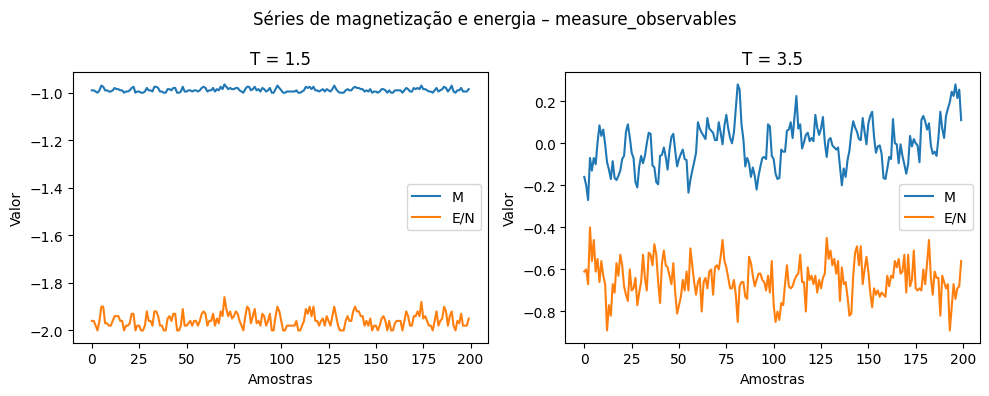

In [ ]:
# Testando measure_observables

# --- parâmetros ---
L = 20
T_list = [1.5, 3.5]   # uma abaixo e uma acima de Tc
n_therm = 1000
n_sweeps = 200
sample_every = 1

plt.figure(figsize=(10,4))
for i, T in enumerate(T_list, 1):
    lat = begin_lattice(L, tipo="random", seed=123)
    run_equilibrate(lat, T, n_therm)

    M_samples, E_samples = measure_observables(lat, T, n_sweeps, sample_every)

    plt.subplot(1,2,i)
    plt.plot(M_samples, label="M")
    plt.plot(E_samples/ (L*L), label="E/N")  # energia por spin
    plt.title(f"T = {T}")
    plt.xlabel("Amostras")
    plt.ylabel("Valor")
    plt.legend()

plt.suptitle("Séries de magnetização e energia – measure_observables")
plt.tight_layout()
plt.show()

Observamos que para T abaixo de T_c a magnetização fica em torno de -1 ou +1, como esperado, já para T acima de T_c a magnetização flutua em torno de 0, também como esperado. Já a energia por partícula tende a flutuar mais de forma constante nos dois caso, pois esperamos que após termalizado a energia do sistema não se altere mais

In [ ]:
# Teste compute_observables

# --- parâmetros ---
L = 16
T_list = [1.5, 2.3, 3.5]
n_therm = 2000
n_sweeps = 3000
sample_every = 10

for T in T_list:
    lat = begin_lattice(L, tipo="random")
    run_equilibrate(lat, T, n_therm)
    M_samples, E_samples = measure_observables(lat, T, n_sweeps, sample_every)
    M_abs, chi, C, U, E_mean = compute_observables(M_samples, E_samples, T, L)
    print(f"T={T:.2f} | M_abs={M_abs:.3f} | chi={chi:.3f} | C={C:.3f} | U={U:.3f}")

T=1.50 | M_abs=0.986 | chi=0.028 | C=0.205 | U=0.666
T=2.30 | M_abs=0.615 | chi=5.883 | C=1.584 | U=0.559
T=3.50 | M_abs=0.132 | chi=0.617 | C=0.261 | U=0.122


/tmp/ipython-input-1859270215.py:320: RuntimeWarning: invalid value encountered in divide
  U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)


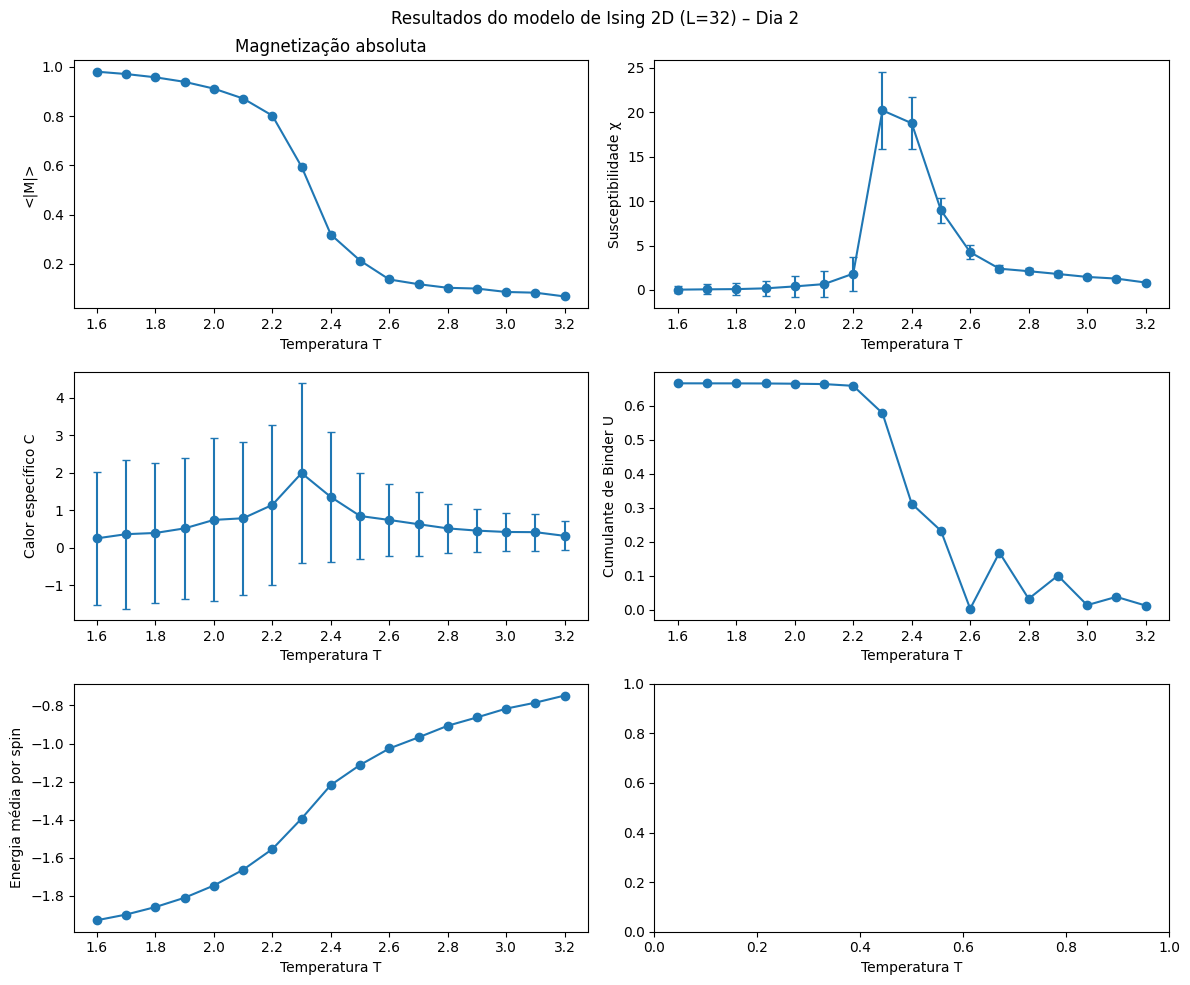

In [ ]:
# Teste completo dia 2 com barras de erro (demora de 50 minutos refazer com menos no futuo)

# --- parâmetros ---
L = 32
T_values = np.arange(1.6, 3.3, 0.1)   # de 1.6 até 3.2
n_therm = 2000
n_sweeps = 5000
sample_every = 10
seed = 42

# roda simulação
results = scan_temperature(L, T_values, n_therm, n_sweeps, sample_every, seed=seed)

# converte para arrays
T = np.array([r["T"] for r in results])
M_abs = np.array([r["M_abs"] for r in results])
dM = np.array([r["dM_abs"] for r in results])
chi = np.array([r["chi"] for r in results])
dchi = np.array([r["dchi"] for r in results])
C = np.array([r["C"] for r in results])
dC = np.array([r["dC"] for r in results])
U = np.array([r["U"] for r in results])
dU = np.array([r["dU"] for r in results])
E_mean = np.array([r["E_mean"] for r in results])
dE = np.array([r["dE"] for r in results])

# --- Plots finais ---
fig, axs = plt.subplots(3,2, figsize=(12,10))

axs[0,0].errorbar(T, M_abs, yerr=dM, fmt="o-", capsize=3)
axs[0,0].set_ylabel("<|M|>")
axs[0,0].set_title("Magnetização absoluta")

axs[0,1].errorbar(T, chi, yerr=dchi, fmt="o-", capsize=3)
axs[0,1].set_ylabel("Susceptibilidade χ")

axs[1,0].errorbar(T, C, yerr=dC, fmt="o-", capsize=3)
axs[1,0].set_ylabel("Calor específico C")

axs[1,1].errorbar(T, U, yerr=dU, fmt="o-", capsize=3)
axs[1,1].set_ylabel("Cumulante de Binder U")

axs[2,0].errorbar(T, E_mean/(L*L), yerr=dE/(L*L), fmt="o-", capsize=3)
axs[2,0].set_ylabel("Energia média por spin")

for ax in axs.flat:
    ax.set_xlabel("Temperatura T")

plt.suptitle(f"Resultados do modelo de Ising 2D (L={L}) – Dia 2")
plt.tight_layout()
plt.show()

"""
df = pd.DataFrame(results)  # results é a lista de dicts retornada pelo scan_temperature

cols = ["T",
        "M_abs","dM_abs",
        "chi","dchi",
        "C","dC",
        "U","dU",
        "E_mean","dE"]

df = df[cols].sort_values("T").reset_index(drop=True)

# printar bonitinho
print(df.round(4).to_string(index=False))

# salvar CSV
csv_name = f"ising_L{L}_day2_results.csv"
df.round(6).to_csv(csv_name, index=False)
print(f"\nArquivo salvo: {csv_name}")
"""

**Interpretação Física dos resultados acima encontrados:**



*  **Magnetização absoluta vs Temperaturas**: Para T baixo, os spins se encontram todos alinhados $⟨|M|⟩ ≈ 1 $ indicando a fase ferromagnética. Para T alta  $⟨|M|⟩$  $≈ 0 $ indicando a transição para fase paramagnética, spins desordenados. Perto de T_c $≈$ 2.2-2.3 observamos a transição entre as fases, onde ocorre a queda brusca da magnetização.

* **Susceptibilidade $χ$ vs T:** Para T baixo e pequeno os spins são pouco responsíveis a pequenas flutuações de campo, todos permanecem desornados (Alto T) ou ordenados (baixo T). Já perto da temperatura crítica observamos um pico na susceptibilidade indicando flutuações críticas dos spins próximos a esse valor (qualquer flutuação muda completamente os estados em volta) isso indica o sinal mais claro da transição e está exatamente como esperado no gráfico  T_c $≈$ 2.2-2.3.

* **Calor Escífico C vs T:** Observamos o pico do calor específico próximo a T_c, mas com barras de erro maiores (isso acontece pq a estimativa do calor específico converge mais devagar, ou seja, precisariamos de mais runs ou uma rede maior ). Em T muito baixa e muito alta, C $≈$ 0, o sistema não consegue armazenar energia com facilidade e portanto está de acordo com o esperado (quer permanecer ordenado para baixo T e para alto T o sistema já se encontra totalmente desornado e fornecer mais energia não permite que ele a armazene), como esperado temos um pico próximo a T_c

* **Cumulante de Binder vs T:** Para T baixo: U $≈ $ 2/3 (valor universal da fase ordenada), de acordo com o esperado. Para T alta: U $→$ 0m (distribuição gaussiana centrada em 0). Queda brunca quando T $≈$ T_c, também de caordo com o esperado. Esse é o gráfico crucial para encontrarmos os exponentes críticos e crucial para os próximas etapas dos códigos (cruzamentos de Binder do artigo)

* **Energia média por spin E/N vs T:** Em T baixa: E/N $≈$ -2 (spins alinhados, cada spin tem 4 vizinhos iguais).  Em T alta: E/N $→$ 0 (spins desordenados). Cruva suave e monotônica, como esperado.




## Testes  (Dia 3)


   T       U  dU
2.20 0.64826 0.0
2.22 0.65170 0.0
2.24 0.60494 0.0
2.26 0.64097 0.0
2.28 0.60550 0.0
2.30 0.55330 0.0
2.32 0.45182 0.0
2.34 0.54873 0.0

CSV salvo: binder_L24.csv


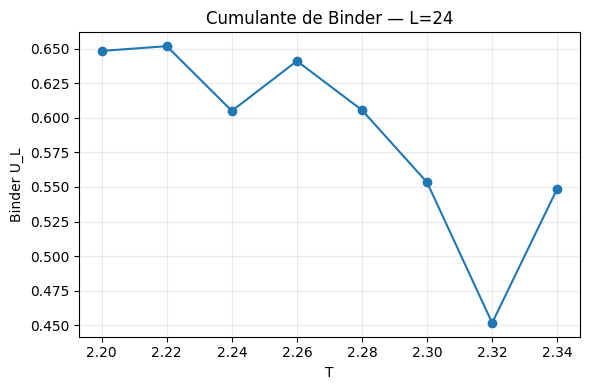

In [ ]:
# Teste função build_binder_curve

# Parâmetros "rápidos"
L = 24
T_values = np.arange(2.20, 2.34 + 1e-12, 0.02)  # poucas temperaturas perto de Tc
n_therm = 1000
n_sweeps = 3000
sample_every = 10
seed = 123
csv_path = f"binder_L{L}.csv"

# === roda e coleta U(T) ===
T, U, dU = build_binder_curve(
    L=L, T_values=T_values, n_therm=n_therm, n_sweeps=n_sweeps,
    sample_every=sample_every, seed=seed, save_csv_path=csv_path
)

# Tabela
df = pd.DataFrame({"T": T, "U": U, "dU": dU})
print(df.round(5).to_string(index=False))
print(f"\nCSV salvo: {csv_path}")

# Gráfico
plt.figure(figsize=(6,4))
plt.errorbar(T, U, yerr=dU, fmt="o-", capsize=3)
plt.xlabel("T")
plt.ylabel("Binder U_L")
plt.title(f"Cumulante de Binder — L={L}")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

U_interp(2.275) = 0.617722


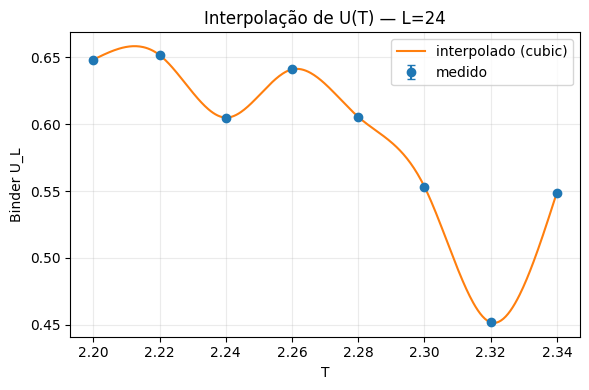

In [ ]:
# Teste 2 - Interpolate_U

# Reaproveita a curva do Teste 1 (T, U, dU)
U_interp = interpolate_U(T, U, kind="cubic", bounds="raise")

# Avalia em uma malha fina (curva contínua)
Tfine = np.linspace(T.min(), T.max(), 400)
Ufine = U_interp(Tfine)

# Mostra também valor em um T alvo
t_star = 2.275
print(f"U_interp({t_star:.3f}) = {float(U_interp(t_star)):.6f}")

# Gráfico: pontos medidos x curva interpolada
plt.figure(figsize=(6,4))
plt.errorbar(T, U, yerr=dU, fmt="o", capsize=3, label="medido")
plt.plot(Tfine, Ufine, "-", label="interpolado (cubic)")
plt.xlabel("T")
plt.ylabel("Binder U_L")
plt.title(f"Interpolação de U(T) — L={L}")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

/tmp/ipython-input-2970611738.py:332: RuntimeWarning: invalid value encountered in divide
  U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)


Cruzamento (L=24,48): T* = 2.283484, U* = 0.639514


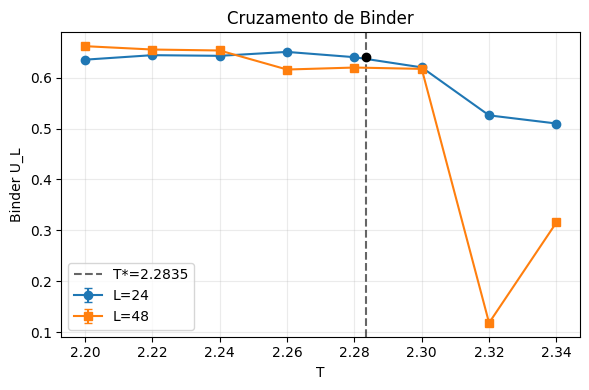

In [ ]:
# Teste 3 - Encontra o valor de cruzamento (TESTE)

# Parâmetros "rápidos"
L1, L2 = 24, 48
T_values = np.arange(2.20, 2.34 + 1e-12, 0.02)
n_therm = 1200   # um pouco mais para L maior
n_sweeps = 3200
sample_every = 10
seed = 321

# Curva para L1
T1, U1, dU1 = build_binder_curve(
    L=L1, T_values=T_values, n_therm=n_therm, n_sweeps=n_sweeps,
    sample_every=sample_every, seed=seed, save_csv_path=f"binder_L{L1}.csv"
)

# Curva para L2
T2, U2, dU2 = build_binder_curve(
    L=L2, T_values=T_values, n_therm=int(1.5*n_therm), n_sweeps=int(1.5*n_sweeps),
    sample_every=sample_every, seed=seed+1, save_csv_path=f"binder_L{L2}.csv"
)

# Cruzamento
t_cross, U_cross = find_crossing(T1, U1, T2, U2, kind="cubic", grid_points=800)
print(f"Cruzamento (L={L1},{L2}): T* = {t_cross:.6f}, U* = {U_cross:.6f}")

# Plot das duas curvas e do cruzamento
plt.figure(figsize=(6,4))
plt.errorbar(T1, U1, yerr=dU1, fmt="o-", capsize=3, label=f"L={L1}")
plt.errorbar(T2, U2, yerr=dU2, fmt="s-", capsize=3, label=f"L={L2}")
plt.axvline(t_cross, color="k", linestyle="--", alpha=0.6, label=f"T*={t_cross:.4f}")
plt.scatter([t_cross], [U_cross], c="k", zorder=5)
plt.xlabel("T")
plt.ylabel("Binder U_L")
plt.title("Cruzamento de Binder")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

Aqui já temos uma estimativa extremamente boa para a tempeartura crítica desse sistema.

/tmp/ipython-input-2970611738.py:332: RuntimeWarning: invalid value encountered in divide
  U_bs, dU = bootstrap(1 - (M_samples**4)/(3*(M_samples**2)**2), n_resamples)



Cruzamentos:
 L  T_cross(L,2L)
16       2.251270
24       2.280286
32       2.253461

Estimativa Tc (extrapolação): 2.273365
Intercepto ± erro (ajuste): 2.273365 ± 0.046117  |  R^2 = 0.06509
Estimativa Tc (média): 2.261672  ± 0.009328


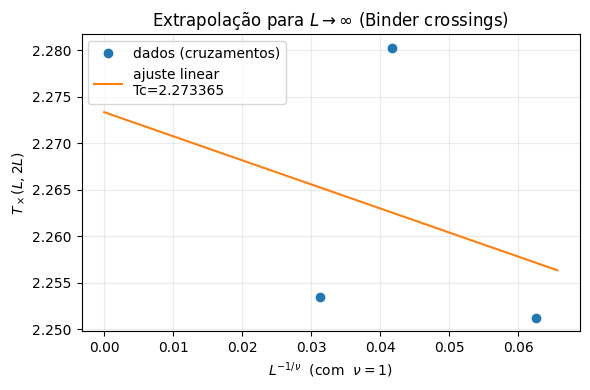

In [ ]:
# Teste 4, encontrar T_c com base no cruzamento de diversas redes (Teste final)

# Parâmetros "rápidos" (reduzidos para tempo de execução)
Ls = [16, 24, 32]            # se der tempo, adicione 48
T_values = np.arange(2.22, 2.32 + 1e-12, 0.02)  # janela mais estreita
n_therm_base = 1000
n_sweeps_base = 3000
sample_every = 10
seed0 = 42

crossings = []

for k, L in enumerate(Ls):
    # curva para L
    T1, U1, dU1 = build_binder_curve(
        L=L, T_values=T_values,
        n_therm=int(n_therm_base*(L/24)),
        n_sweeps=int(n_sweeps_base*(L/24)),
        sample_every=sample_every,
        seed=seed0 + 2*k,
        save_csv_path=f"binder_L{L}.csv"
    )
    # curva para 2L
    L2 = 2*L
    T2, U2, dU2 = build_binder_curve(
        L=L2, T_values=T_values,
        n_therm=int(n_therm_base*(L2/24)),
        n_sweeps=int(n_sweeps_base*(L2/24)),
        sample_every=sample_every,
        seed=seed0 + 2*k + 1,
        save_csv_path=f"binder_L{L2}.csv"
    )

    # cruzamento (sem erro individual aqui)
    t_cross, _ = find_crossing(T1, U1, T2, U2, kind="cubic", grid_points=800)
    crossings.append((L, t_cross))  # Pode incluir dt depois

# Tabela de cruzamentos
dfc = pd.DataFrame(crossings, columns=["L", "T_cross(L,2L)"]).sort_values("L")
print("\nCruzamentos:")
print(dfc.round(6).to_string(index=False))

# Estimativa de Tc — extrapolação (nu=1 para Ising 2D)
Tc, info = estimate_Tc_from_crossings(
    crossings, method="extrapolate", nu=1.0, return_fit=True
)
print(f"\nEstimativa Tc (extrapolação): {Tc:.6f}")
print(f"Intercepto ± erro (ajuste): {info['intercept']:.6f} ± {info['intercept_err']:.6f}  |  R^2 = {info['R2']:.5f}")

# Estimativa de Tc — média simples (atalho)
Tc_avg, info_avg = estimate_Tc_from_crossings(
    crossings, method="average", return_fit=True
)
print(f"Estimativa Tc (média): {Tc_avg:.6f}  ± {info_avg.get('Tc_err', np.nan):.6f}")

# Plot: T_cross vs 1/L^{1/nu} com reta do fit
x = info["x"]           # = L^{-1/nu}
y = info["y"]           # = T_cross
a = info["slope"]       # coef angular
b = info["intercept"]   # intercepto ~ Tc

xline = np.linspace(0, x.max()*1.05, 200)
yline = a*xline + b

plt.figure(figsize=(6,4))
plt.plot(x, y, "o", label="dados (cruzamentos)")
plt.plot(xline, yline, "-", label=f"ajuste linear\nTc={b:.6f}")
plt.xlabel(r"$L^{-1/\nu}$  (com  $\nu=1$)")
plt.ylabel(r"$T_\times(L,2L)$")
plt.title("Extrapolação para $L\\to\\infty$ (Binder crossings)")
plt.legend()
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()